## MCC NMIBC Pre-repeat Urine MRD analysis

In [1]:
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(maftools)
library(RColorBrewer)
library(readxl)
library(stats)
library(pROC)
library(stringr)
source("~/Desktop/puffin/R/helper_functions.R")
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=100)
source("../fix_PIDs.R")

# set some defaults
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=100)
formals(table)$useNA <- "always"
formals(write.csv)$row.names <- FALSE
formals(write.csv)$as.is <- TRUE

print(Sys.time())
print(sessionInfo())

Warning message:
“package ‘ggplot2’ was built under R version 4.3.1”
── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either

[1] "2024-03-14 13:06:05 PDT"
R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 14.1.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggsignif_0.6.4        glue_1.6.2            pROC_1.18.4          
 [4] readxl_1.4.3          RColorBrewer_1.1-3    maftools_2.16.0      
 [7] ComplexHeatmap_2.16.0 lubridate_1.9.2       forcats_1.0.0        
[10] stringr_1.5.0         dplyr_1.1.2           purrr_1.0.1          
[13] readr_2.1.4           tidyr_1.3.0           tibble_3.2.1         
[16] tidyverse_

### pipeline notes on the mrd output file, see deepsea func callMRD and local annotated version of function
- mutationCount = length(variants.f), # count of Beacon sample variants that are somatic, and finalKeep or white.list
- mutationCount.mrd = length(variants.mrd), # number of quality filtered T00 personalized variants detected           
- mutationCount.mrd.f = length(variants.mrd.sig), ## number filtered T00 personal variants that have changed signif. in freuqncy from baseline (i.e. are not germlines mistaken for somatics)                       
- mrd.status = mrd.status,  ## total mrd.score across variants is >1.5
- tumorFraction = tumorFraction, # beacon sample tumorFraction calculated from variants.mrd.sig.f markers, or if none calculated from the other baseline-matching variants

In [2]:
# read in clinical data

## functions for harmonizing input sheets
source("../fix_PIDs.R")

fix_sampleTypes <- function(col){
    #print(table(col, useNA="always"))
    col.new <- gsub("FFPE", "Tissue", col)
    col.new <- gsub("Urine_Supernatant|Supernatant", "Urine", col.new)
    col.new <- gsub("Buffy Coat|PBMC", "Buffy_Coat", col.new)
    print(table(col.new, useNA="always"))
    return(col.new)
}
fix_StudyVisit <- function(col){
    warn_na(col)
    col.new <- sapply(str_split(col, pattern="_"), "[", 2)
    return(col.new)
}


df_clin = read.csv("./clinical_data/NMIBC_clinical_data_merged_2023-10-11.csv", as.is=T) %>%
                mutate(PatientID=as.character(PatientID))
stopifnot(all(!duplicated(df_clin$PatientID)))
print(df_clin$PatientID)
names(df_clin)
table(df_clin$disease.positive) # no clin data on validation cohort samples

 [1] "152237" "161922" "169558" "172530" "173254" "173912" "174091" "174872"
 [9] "175648" "175733" "175980" "176349" "176388" "180264" "182022" "116381"
[17] "165028" "167162" "171374" "171769" "171821" "172153" "172229" "172586"
[25] "172602" "172749" "172851" "173075" "173281" "173334" "173350" "173359"
[33] "173362" "173509" "173975" "173983" "175610" "174083" "174947" "175325"
[41] "175387" "175425" "175492" "175526" "175672" "175725" "175854" "176828"
[49] "176992" "177967" "178886" "175831" "179692" "181439" "181568" "182435"
[57] "182910" "184289" "184485" "184615" "184957" "185014" "185212" "185382"
[65] "185581" "186478" "186652" "187204" "187807" "188867" "189083" "189342"
[73] "190233" "191632" "191692" "192682" "193186"


[1] "PatientID"                                                                                                      
 [2] "has.IndexTURBT"                                                                                                 
 [3] "Age"                                                                                                            
 [4] "Sex"                                                                                                            
 [5] "Race"                                                                                                           
 [6] "Smoking.Status"                                                                                                 
 [7] "ECOG.scoreAt.Repeat.TURBT"                                                                                      
 [8] "Previous.pelvic.XRT"                                                                                            
 [9] "Previous.history.of.NMIBC"                                                                                      
[10] "Progression"                                                                                                    
[11] "Previous.Intravesical.Therapy..choice.None."                                                                    
[12] "Previous.Intravesical.Therapy..choice.BCG."                                                                     
[13] "Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel."                                               
[14] "Previous.Intravesical.Therapy..choice.Mitomycin.C."                                                             
[15] "Other.Intravesical.Therapy"                                                                                     
[16] "Prior.Treatment.Free.Text..1.2.sentence.summary.of.treatment.prior.to.Index.TURBT.inclusive.of.NMIBC.Pathology."
[17] "Index.TURBT.Date"                                                                                               
[18] "IndexHistology"                                                                                                 
[19] "Variant.Histology"                                                                                              
[20] "Index.Stage"                                                                                                    
[21] "IndexGrade"                                                                                                     
[22] "Index.CIS"                                                                                                      
[23] "LVI...35"                                                                                                       
[24] "Immediate.Post.Op.Intravesical.Therapy.Index"                                                                   
[25] "Repeat.TURBT.Date"                                                                                              
[26] "RepeatHistology"                                                                                                
[27] "Variant.Histology.Repeat"                                                                                       
[28] "Repeat.Stage"                                                                                                   
[29] "RepeatGrade"                                                                                                    
[30] "Repeat.CIS"                                                                                                     
[31] "LVI...43"                                                                                                       
[32] "Immediate.Post.Op.Intravesical.Therapy.Repeat"                                                                  
[33] "Induction.Intravesical.Therapy.Administered."                                                                   
[34] "Induction.Intravesical.Therapy.Type."                               


FALSE  TRUE  <NA> 
   15    35    27 

In [47]:
# Master sample list from manifests
df_samples_all = read_excel("./NMIBC_STUDY_PLAN_and_avail_data_BG_02052024.xlsx", sheet="all_Recieved_samples_FZ") %>%
                mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict"),
                       PatientID = fix_PIDs(PatientID)) %>%
                separate(StudyVisit, sep="_",into = c("pid", "StudyVisit2"), remove = FALSE) %>%
                mutate(StudyVisit = gsub(" ","",ifelse(!is.na(StudyVisit2), StudyVisit2, StudyVisit)),
                      SampleType = fix_sampleTypes(SampleType))
table(df_samples_all$SampleType, df_samples_all$StudyVisit, useNA="always")
stopifnot(all(!(duplicated(df_samples_all$SampleID.short)))) #253
nrow(df_samples_all) # 558

# Lab QC
df_lab_qc = read_excel("NMIBC_STUDY_PLAN_and_avail_data_BG_02052024.xlsx", sheet="LabQC") %>%
                mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict"),
                       PatientID = fix_PIDs(PatientID)) %>%
                separate(StudyVisit, sep="_",into = c("pid", "StudyVisit2"), remove = FALSE) %>%
                mutate(StudyVisit = gsub(" ","",ifelse(!is.na(StudyVisit2), StudyVisit2, StudyVisit)),
                      SampleType = fix_sampleTypes(SampleType))
table(df_lab_qc$SampleType, df_lab_qc$StudyVisit, useNA="always")
stopifnot(all(!duplicated(df_lab_qc$SampleID)))
nrow(df_lab_qc) #369 samples

SampleID.short format: strict
 [1] "172602" "172851" "172586" "173983" "173359" "169558" "161922" "172530"
 [9] "173362" "172153" "172229" "173334" "171374" "173509" "171769" "175610"
[17] "175492" "152237" "176992" "177967" "173350" "178886" "175526" "175733"
[25] "175725" "171821" "174083" "182022" "174872" "175425" "176388" "175854"
[33] "175980" "175672" "173975" "173912" "176349" "174947" "176828" "180264"
[41] "172749" "175325" "165028" "167162" "175387" "175648" "173254" "174091"
[49] "173281" "173075" "116381" "182910" "179692" "181439" "181568" "184485"
[57] "175831" "185014" "184615" "184289" "184957" "186652" "185581" "185382"
[65] "185212" "182435" "187204" "186478" "187807" "188867" "189342" "189083"
[73] "190233" "191692" "191632" "192682" "193186" "196111" "196412" "195312"
[81] "195407" "195874" "194171" "195778" "195451" "194650" "193330" "193187"
[89] "193248" "189953" "187260" "185159" "182170" "178919" "76224"  "173743"


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 620 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


col.new
        Buffycoat            Plasma            Tissue             Urine 
               92                92               175               161 
Urine Cell Pellet              <NA> 
              160                 0 


                   
                    BenignUrothelium FollowUp1 FollowUp2 FollowUp3 Followup4
  Buffycoat                        0         0         0         0         0
  Plasma                           0         0         0         0         0
  Tissue                           9         0         0         0         0
  Urine                            0        18         9         4         1
  Urine Cell Pellet                0        18         9         4         1
  <NA>                             0         0         0         0         0
                   
                    IndexTURBT PostTURBT Pre-RepeatTURBT RepeatTURBT
  Buffycoat                  0         0              92           0
  Plasma                     0         0              92           0
  Tissue                    94         0               0          72
  Urine                      0        30              96           0
  Urine Cell Pellet          0        29              96           0
  <NA> 

[1] 680

SampleID.short format: strict
 [1] "172602" "172851" "172586" "173983" "173359" "169558" "161922" "172530"
 [9] "173362" "172153" "172229" "173334" "171374" "173509" "171769" "175610"
[17] "175492" "152237" "176992" "177967" "173350" "178886" "175526" "175733"
[25] "175725" "171821" "174083" "182022" "174872" "175425" "176388" "175854"
[33] "175980" "175672" "173975" "173912" "176349" "174947" "176828" "180264"
[41] "172749" "175325" "165028" "167162" "175387" "175648" "173254" "174091"
[49] "173281" "173075" "116381" "182910" "179692" "181439" "181568" "184485"
[57] "175831" "185014" "184615" "184289" "184957" "186652" "185581" "185382"
[65] "185212" "182435" "187204" "186478" "187807" "188867" "189342" "189083"
[73] "190233" "191692" "191632" "192682" "193186" "196111" "196412" "195312"
[81] "195407" "195874" "194171" "195778" "195451" "194650" "193330" "193187"
[89] "193248" "189953" "187260" "185159" "182170" "178919" "173743" "76224" 


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 329 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


col.new
Buffy_Coat     Plasma     Tissue        UCP      Urine       <NA> 
        73         15        158         28        160          0 


            
             BenignUrothelium FollowUp1 FollowUp2 FollowUp3 IndexTURBT
  Buffy_Coat                0         0         0         0          0
  Plasma                    0         0         0         0          0
  Tissue                    9         0         0         0         73
  UCP                       0         0         0         0          0
  Urine                     0        18         9         4          0
  <NA>                      0         0         0         0          0
            
             PostTURBT Pre-RepeatTURBT RepeatTURBT Surveillance1 <NA>
  Buffy_Coat         0              73           0             0    0
  Plasma             0              15           0             0    0
  Tissue             0               0          31             0   45
  UCP               10              15           0             3    0
  Urine             30              96           0             3    0
  <NA>               0               0           0       

[1] 434

# Pre-repeat Urine MRD

In [79]:
## rerun batch 1+2 old MRD data form 2022
# df_ngsqc.old = read.csv("data_batch1_and_2/Urine-UCP/Urine_post_analysis/PD_12-02-2022_beacon_results/PRDC-MOFFITT-NMIBC-22001_MRD_Info_combined.csv")

# df_ngsqc.old = df_ngsqc.old %>% select(-PatientID) %>%
#                         left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
#                         rename("StudyVisit.sample"="StudyVisit") %>% 
#                         mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
#                                StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
#                                #PatientID.old.sample = PatientID.sample,
#                                #PatientID.sample = as.character(fix_PIDs(PatientID.old.sample))
#                               )
# df_ngsqc.old = df_ngsqc.old %>% left_join(df_clin %>% select(PatientID, disease.positive), by="PatientID")

# df_ngsqc.old = df_ngsqc.urine.mrd %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()

# table(df_ngsqc.old$PatientID, df_ngsqc.old$StudyVisit.sample)
# df_ngsqc.old = df_ngsqc.old %>% mutate("Tumor.Fraction.Percent"=tf.m.f*100,
#                                                   "disease.positive"=factor(disease.positive, levels=c("FALSE","TRUE")))

# jpeg("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/PD_12-02-2022_beacon_results/MCC_NMIBC_BEACON_preRepeat_boxplot_10252023.jpeg",
#     height=7, width=8, units="in", res=72)
# quick_boxplot(df_ngsqc.old, x = "disease.positive", y="Tumor.Fraction.Percent",
#              colors=c("FALSE"="blue","TRUE"="darkred"), log.axes = TRUE, log.0.adj=0.001)
# dev.off()
# slightly diff b/c of log.0.adjust and not filling the lod

        
         Pre-RepeatTURBT <NA>
  161922               1    0
  169558               1    0
  171769               1    0
  172229               1    0
  172530               1    0
  172586               1    0
  172851               1    0
  173334               1    0
  173362               1    0
  173509               1    0
  173983               1    0
  <NA>                 0    0

Complete cases Tumor.Fraction.Percent by disease.positive: 11
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             8     TRUE (n=8)  darkred
FALSE median: 0.0344059075456777
TRUE median: 2.89147999269167

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 2, p-value = 0.05248
alternative hypothesis: true location shift is not equal to 0

  disease.positive Tumor.Fraction.Percent    label
1            FALSE               57.41412 p=0.0525
2             TRUE                     NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


pdf 
  2

In [4]:
## all pre-repeat UR sample MRD NGSQC data
# recalculate batch 1+2 mrd with new multibaseline pipeline 

#####
print("Batch1")
# old data - no baseline sample info
#df_1n2 = read.csv("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/PD_12-02-2022_beacon_results/PRDC-MOFFITT-NMIBC-22001_MRD_Info_combined.csv") 

# new data - but needs to be rerun with updated multi.baseline pipeline code
df_1n2 = read.csv("./tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011_Other_all_2023-11-06.csv")
# add one sample rerun data 11/7
df_1n2 = df_1n2 %>% filter(SampleID != "P219770")
df_mis = read.csv("./tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011/P219770_consensus_mrdInfo.csv")
df_1n2 = rbind.common(df_1n2, df_mis)
df_1n2 %>% group_by(SampleID) %>% summarize(n())


print("Batch3")
df_3 = read.csv("./tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP001172_PRDC_MOFFITT_batch3_pre_urine_mrd/WOP01172_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all-PD_10202023.csv") 
df_3 %>% group_by(SampleID) %>% summarize(n())

## combine
df_ngsqc.preur = rbind.common(df_1n2,df_3)
df_ngsqc.preur = df_ngsqc.preur %>%
        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")) %>% 
        select(-PatientID) %>% distinct()
nrow(df_ngsqc.preur)

#df_ngsqc.urine.mrd %>% filter(grepl("fail", QC_Status, ignore.case=TRUE)) # none

#### add sample studyvisit and PID
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
                        rename("StudyVisit.sample"="StudyVisit", "PatientID.sample"="PatientID", 
                               "SampleID.short.sample"="SampleID.short", "SampleID.sample"="SampleID") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
                               StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
                               PatientID.old.sample = PatientID.sample,
                               PatientID.sample = as.character(fix_PIDs(PatientID.old.sample)))

df_ngsqc.preur = df_ngsqc.preur %>% filter(!grepl("specific|pool", Baseline, ignore.case = T))

### add baseline study visit
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by=c("Baseline"="SampleID.short")) %>%
                        rename("StudyVisit.baseline"="StudyVisit", "PatientID.baseline"="PatientID",
                               "SampleID.baseline"="Baseline") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.baseline),
                               StudyVisit.baseline = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.baseline, StudyVisit2))),
                               PatientID.old.baseline = PatientID.baseline,
                               PatientID.baseline = as.character(fix_PIDs(PatientID.old.baseline)))

df_ngsqc.preur = df_ngsqc.preur %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()

head(df_ngsqc.preur)
df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")
table(df_ngsqc.preur$SampleID.sample, df_ngsqc.preur$StudyVisit.baseline)

stopifnot(all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline))

table(df_ngsqc.preur$StudyVisit.sample) 

[1] "Batch1"


SampleID,n()
<chr>,<int>
P217590,1
P217591,1
P217592,1
P217594,1
P217595,1
P217596,1
P217598,1
P217599,1
P217601,1


[1] "Batch3"


SampleID,n()
<chr>,<int>
P228666,4
P228670,4
P228674,3
P228675,4
P228676,4
P228678,1
P228679,3
P228680,1
P228681,3


SampleID.short format: remove.suffix


[1] 77

 [1] "172586" "172530" "172851" "161922" "171769" "172229" "173362" "173983"
 [9] "169558" "173334" "175492" "173350" "175725" "171821" "174083" "174872"
[17] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[25] "174947" "174091" "176828" "180264" "175325" "173281" "173075" "116381"
[33] "167162" "175387" "175648"
 [1] "172586" "172530" "172851" "161922" "171769" "172229" "173362" "173983"
 [9] "169558" "173334" "175492" "173350" "175725" "171821" "174083" "174872"
[17] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[25] "174947" "174091" "176828" "180264" "175325" "173281" "173075" "116381"
[33] "167162" "175387" "175648"


,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction,tumorFraction.mrd,SampleID.short.sample,StudyVisit.sample,PatientID.sample,StudyVisit2,PatientID.old.sample,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P219768,P220082,5,5,73,1,1,1,0.000,0.000,FALSE,TRUE,0,0.000511117,0.000000000,0.000000000,0.04111842,0.27262813,6.7612,0.28133,0.28133,0.000000000,0.001874776,0.000000000,0.0000000,0.00000000,P219768,Pre-RepeatTURBT,173362,NA,173362,IndexTURBT,173362,173362
2,P217592,P220085,36,36,0,38,36,36,30.125,31.625,TRUE,TRUE,1,0.022549160,0.016272510,0.013385260,10.80395545,0.09633794,51.9150,0.68347,0.68347,0.168910716,0.234063133,0.138940693,0.1950100,0.19501029,P217592,Pre-RepeatTURBT,173983,NA,173983,IndexTURBT,173983,173983
3,P217594,P220073,34,34,0,34,33,31,16.025,16.025,TRUE,TRUE,0,0.003252546,0.001770314,0.001336200,0.89898273,0.07938568,23.4690,0.26590,0.26590,0.022300174,0.040971448,0.016831757,0.0178190,0.01781946,P217594,Pre-RepeatTURBT,169558,NA,169558,IndexTURBT,169558,169558
4,P219771,P220076,79,78,1,76,73,70,59.800,60.800,TRUE,TRUE,1,0.002797925,0.002641349,0.001420949,0.54013783,0.20652446,59.8930,0.66059,0.66059,0.012789522,0.013547670,0.006880296,0.0107450,0.01074472,P219771,Pre-RepeatTURBT,173334,NA,173334,IndexTURBT,173334,173334
5,P217596,P220079,68,64,4,22,16,6,0.475,0.475,FALSE,TRUE,0,0.000249594,0.000007060,0.000007060,0.04056795,0.13272485,19.9300,0.34690,0.34690,0.000053200,0.001880540,0.000053200,0.0000185,0.00001850,P217596,Pre-RepeatTURBT,172530,NA,172530,IndexTURBT,172530,172530
6,P217590,P220074,40,21,40,20,7,7,6.125,6.125,TRUE,TRUE,0,0.001755319,0.001625665,0.001625665,0.45012603,0.26793088,17.6140,0.67709,0.29952,0.006067479,0.006551388,0.006067479,0.0089622,0.00896218,P217590,Pre-RepeatTURBT,172851,NA,172851,IndexTURBT,172851,172851


         
          IndexTURBT RepeatTURBT <NA>
  P217590          1           0    0
  P217591          0           1    0
  P217592          1           0    0
  P217594          1           0    0
  P217595          1           0    0
  P217596          1           0    0
  P219768          1           0    0
  P219770          1           0    0
  P219771          1           0    0
  P219774          1           0    0
  P228666          1           1    0
  P228670          1           1    0
  P228674          1           1    0
  P228675          1           1    0
  P228676          1           1    0
  P228678          1           0    0
  P228679          1           1    0
  P228680          1           0    0
  P228681          1           1    0
  P228682          1           0    0
  P228683          1           1    0
  P228684          1           1    0
  P228685          1           0    0
  P228686          1           0    0
  P228687          0           1    0
  


Pre-RepeatTURBT            <NA> 
             48               0 

In [5]:
## check patient study inclusion

# "discovery" cohort from shared MCC planning doc 10/11/2023
pre.urine.mrd.patients = c(
"116381",
"152237",
"161922",
"167162",
"169558",
"171769",
"171821",
"172229",
"172530",
"172586", # repeat probes only 
"172749",
"172851",
"173075",
"173281", # repeat TURBT probes only, Index fail                     
#"176828", # 176828 - low ucfDNA
"173334",
#"173350", prUR mislabeled - exclude
"173362",
#"173509", # prUR ex qc fail
"173912",
"173975",
"173983",
"174083",
"174091",
"174872",
"174947", # repeat probes only, Index fail
"175325",
"175387",
"175425",
"175492",
"175648",
"175672",                      
"175725",
"176828", # repeat probes only
"175854",
"175980",
"176349",
"176388",
"177967",
"180264",
"182022")

length(pre.urine.mrd.patients) #38 patients, 4 with Repeat only baseline

# no missing patients
stopifnot(length(pre.urine.mrd.patients[pre.urine.mrd.patients %!in% df_ngsqc.preur$PatientID]) > 0)

## any extra patients?
df_ngsqc.preur$PatientID[df_ngsqc.preur$PatientID %!in% pre.urine.mrd.patients] 


# 175672 - mrd ok
# 175648 - ok for mrd - P228699
# 173281 - PBMC fail, analyze separate - ok for mrd
# 152237 - low quality germline - PBMC extraction pass sample P228635 - ngsqc pass: likely mislabeled, use as no PBMC
# excluded
# 173350−preRepeat_Supernatant−P228670 - sample does not cluster with other patient samples - labQC pass - ngsqc pass: mislabeled, exclude
# 176828 - low ucfDNA

# repeat TURB probes only
# 173281, Index FAIL
# 174947, Index FAIL
# 172586 
# 176828

# from online planning doc
patients.WO.pbmc = c("116381","152237","173075","173254","173281","174091","175831")

df_ngsqc.preur= df_ngsqc.preur %>% filter(PatientID %in% pre.urine.mrd.patients) %>%
                            mutate(has.PBMC = PatientID %!in% patients.WO.pbmc)

nrow(df_ngsqc.preur) # many patients two baselines
table(df_ngsqc.preur$PatientID, df_ngsqc.preur$StudyVisit.baseline)
table(df_ngsqc.preur$StudyVisit.sample) # 46 

[1] 38

[1] "173350" "173350"

[1] 46

        
         IndexTURBT RepeatTURBT <NA>
  116381          1           1    0
  161922          1           0    0
  167162          1           1    0
  169558          1           0    0
  171769          1           0    0
  171821          1           1    0
  172229          1           0    0
  172530          1           0    0
  172586          0           1    0
  172851          1           0    0
  173075          1           0    0
  173281          0           1    0
  173334          1           0    0
  173362          1           0    0
  173912          1           0    0
  173975          1           1    0
  173983          1           0    0
  174083          1           1    0
  174091          1           0    0
  174872          1           0    0
  174947          0           1    0
  175325          1           1    0
  175387          1           1    0
  175425          1           1    0
  175492          1           1    0
  175648          1          


Pre-RepeatTURBT            <NA> 
             46               0 

In [6]:
# ADD LPWGS data

######
# batch 1+2: 15 total, patients 11 and 18 did not have enough FFPE for processing, 2 failed
# ffpe 50X WGS
df_ffpe_lpwgs_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/LPWGS/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                                    "samples", warn=F)
df_ffpe_lpwgs_a$PatientID <- fix_PIDs(df_ffpe_lpwgs_a$PatientID)
# urine LPWGS 
df_urine_lpwgs_a1 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                             "samples", warn=F)
df_urine_lpwgs_a1$PatientID <- fix_PIDs(df_urine_lpwgs_a1$PatientID)
df_urine_lpwgs_a2 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_lpwgsQC_missing_05092023.csv", 
                                               as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")), "samples", warn=F)
df_urine_lpwgs_a2$PatientID <- fix_PIDs(df_urine_lpwgs_a2$PatientID)
df_all_lpwgs_a = rbind.common(df_ffpe_lpwgs_a, rbind.common(df_urine_lpwgs_a1, df_urine_lpwgs_a2))

#####
# batch 3
# urine samples
df_urine_lpwgs_b = read.csv("./data_batch3_02222023/LPWGS/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all.csv") %>%
                mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix"))
df_urine_lpwgs_b$PatientID <- fix_PIDs(df_urine_lpwgs_b$PatientID)

####
# validation cohort batch 4 - WOP01194
df_val1_lpwgs = read.csv("./Validation_cohort/LPWGS/WOP01089_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all_file1.csv") 
df_val2_lpwgs = read.csv("./Validation_cohort/LPWGS/WOP01089_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all_file2.csv")
df_val3_lpwgs = read.csv("./Validation_cohort/LPWGS/WOP01089_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all_file3.csv")
df_val_lpwgs = rbind.common(rbind.common(df_val1_lpwgs, df_val2_lpwgs), df_val3_lpwgs) %>%
    mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix")) %>% distinct()

#######
## combine batches
df_lpwgs_all = rbind.common(df_val_lpwgs, rbind.common(df_all_lpwgs_a, df_urine_lpwgs_b)) %>% 
                                mutate(PatientID = as.character(PatientID))
df_lpwgs_all = merge.combine(df_lpwgs_all, df_samples_all %>% select(PatientID, SampleID.short, SampleType, StudyVisit)) %>%
                left_join(df_clin %>% select("PatientID","disease.positive"), by="PatientID") %>%
                mutate("disease.positive"=factor(disease.positive)) %>%
                filter(PatientID %in% pre.urine.mrd.patients) %>% distinct()
stopifnot(all(!duplicated(df_lpwgs_all$SampleID)))
nrow(df_lpwgs_all) # 70
table(df_lpwgs_all$SampleType, df_lpwgs_all$StudyVisit)

#write.csv(df_lpwgs_all, "./tissue_probe_mrd/LPWGS_data_all_11152023.csv", row.names=F)

####
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_lpwgs_all %>% select("SampleID.short",'wgsTumorfrac_ichorCNA','armAbnormalityScore',
                                                                              'fragmentNum','cnbScore','wgsTumorfrac_EM'), 
                                              by=c("SampleID.short.sample"="SampleID.short"))
table(df_ngsqc.preur$StudyVisit.sample)

SampleID.short format: remove.suffix
 [1] "172229" "172586" "172602" "169558" "172851" "173334" "171769" "172530"
 [9] "173362" "173509" "161922" "173983"
SampleID.short format: remove.suffix
 [1] "172586" "173359" "169558" "161922" "172530" "173362" "172153" "172229"
 [9] "173334" "171374" "171769"
SampleID.short format: remove.suffix
 [1] "169558" "161922" "172530" "172602" "172851" "172586" "173983" "173359"
 [9] "173334" "171374" "173509" "171769"
SampleID.short format: remove.suffix
 [1] "175492" "152237" "173350" "175725" "171821" "174083" "182022" "174872"
 [9] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[17] "174947" "174091" "176828" "180264" "172749" "175325" "173281" "173075"
[25] "116381" "165028" "167162" "175648" "173254" "175610" "176992" "175526"
[33] "175733" "175387"


Warning message in file(file, "rt"):
“cannot open file './Validation_cohort/LPWGS/WOP01089_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all_file1.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [67]:
## replot batch1+2 old data for Shidong ~Nov 5
# table(df_lpwgs_all$StudyVisit, df_lpwgs_all$SampleType)

# df_lpwgs = df_lpwgs_all %>% filter(StudyVisit=="Pre-RepeatTURBT", SampleType=="Urine") %>%
#                             mutate("disease.positive"=factor(disease.positive, levels=c("FALSE","TRUE")),
#                                   "WGS.Tumor.Fraction.Percent"=as.numeric(wgsTumorfrac_ichorCNA)*100)

# names(df_lpwgs)

# jpeg("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/MCC_NMIBC_LPWGS_ichorTF_preRepeat_urine_boxplot_10252023.jpg",
#         height=7, width=8, unit="in", res=72)
# quick_boxplot(df_lpwgs, x="disease.positive", y="WGS.Tumor.Fraction.Percent", 
#               log.0.adj = 0.001, log.axes = TRUE, colors=c("FALSE"="blue","TRUE"="darkred"))
# dev.off()

                 
                  Tissue Urine <NA>
  FollowUp1            0     9    0
  IndexTURBT          11     0    0
  PostTURBT            0    29    0
  Pre-RepeatTURBT      0    42    0
  RepeatTURBT          7     0    0
  Surveillance1        0     3    0
  <NA>                 0     0    0

[1] "SampleID"                   "Total.reads..M."           
 [3] "Mapped.reads..M."           "Mapping.rate...."          
 [5] "Consensus.reads..M."        "Duplication.rate...."      
 [7] "Fragment_Size_Mode"         "Softclip.ratio"            
 [9] "ProjectDir"                 "coveredGenomicPect"        
[11] "coverage"                   "qcLabel"                   
[13] "gender"                     "wgsTumorfrac_ichorCNA"     
[15] "armAbnormalityScore"        "fragmentNum"               
[17] "cnbScore"                   "classificationLabel"       
[19] "binNum"                     "cnvbinNum"                 
[21] "cnabinNum"                  "cnlbinNum"                 
[23] "cnvbinRatio"                "neutbinNum"                
[25] "neutbinRatio"               "wgsTumorfrac_EM"           
[27] "externalSampleID"           "SampleID.short"            
[29] "SampleType"                 "StudyVisit"                
[31] "PatientID"                  "disease.positive"          
[33] "WGS.Tumor.Fraction.Percent"

Complete cases WGS.Tumor.Fraction.Percent by disease.positive: 42
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             29    TRUE (n=29)  darkred
FALSE median: 0
TRUE median: 3.82

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 54, p-value = 0.0001614
alternative hypothesis: true location shift is not equal to 0

  disease.positive WGS.Tumor.Fraction.Percent   label
1            FALSE                      38.47 p=2e-04
2             TRUE                         NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


pdf 
  2

In [65]:
write.csv(df_ngsqc.preur, glue("./tissue_probe_mrd/pre_repeat_urine_MRD_all/NMIBC_preUR_MRD_data_batches1to3_{Sys.Date()}.csv"), row.names=F)
write.csv(df_ngsqc.preur, glue("./data_delivery/BEACON/NMIBC_preUR_MRD_data_batches1to3_{Sys.Date()}.csv"), row.names=F)

In [110]:
# add clin data and fill NAs
df_ngsqc.preur = df_ngsqc.preur %>%
                         left_join(df_clin %>% mutate(PatientID = as.character(PatientID)) 
                                       %>% select(PatientID, disease.positive, Repeat.Stage, Index.Stage, Index.CIS, Repeat.CIS), by="PatientID") %>%
     mutate(utDNA.positive=mrd.status)

df_ngsqc.preur = df_ngsqc.preur %>% mutate(disease.positive=factor(disease.positive, levels=c("FALSE","TRUE")))

df_ngsqc.preur$tumorFraction[df_ngsqc.preur$mrd.status=="FALSE"] <- 0.00005  # ratio 0-1, not percentage, use LOD here)
df_ngsqc.preur$tf.m.f[df_ngsqc.preur$mrd.status=="FALSE"] <- 0.0 # tf.m.f can be lower than the LOD if markers detected. if no markers detected, call tf=0
names(df_ngsqc.preur)

[1] "SampleID.sample"               "SampleID.baseline"            
 [3] "mutationCount.baseline.design" "mutationCount.baseline"       
 [5] "excludeCount"                  "mutationCount"                
 [7] "mutationCount.mrd"             "mutationCount.mrd.f"          
 [9] "mrd.score.noNovel"             "mrd.score"                    
[11] "mrd.status"                    "checkDynamic"                 
[13] "includeNovel"                  "tf.m.f"                       
[15] "tf.f"                          "tf.ext.f"                     
[17] "maf"                           "tf.baseline"                  
[19] "maf.baseline"                  "tumorfraction.baseline"       
[21] "tumorfraction.baseline.adj"    "fc.tf.f"                      
[23] "fc.tf.m.f"                     "fc.tf.ext.f"                  
[25] "tumorFraction"                 "tumorFraction.mrd"            
[27] "SampleID.short.sample"         "StudyVisit.sample"            
[29] "PatientID"                     "StudyVisit2"                  
[31] "PatientID.old.sample"          "StudyVisit.baseline"          
[33] "PatientID.baseline"            "PatientID.old.baseline"       
[35] "has.PBMC"                      "wgsTumorfrac_ichorCNA"        
[37] "armAbnormalityScore"           "fragmentNum"                  
[39] "cnbScore"                      "wgsTumorfrac_EM"              
[41] "disease.positive"              "Repeat.Stage"                 
[43] "Index.Stage"                   "Index.CIS"                    
[45] "Repeat.CIS"                    "utDNA.positive"

In [94]:
tmp <- df_ngsqc.preur.index %>% relocate(disease.positive, PatientID, SampleID.sample, StudyVisit.baseline, tumorFraction, tumorFraction.mrd)
write.csv(tmp, "./tissue_probe_mrd/pre_repeat_urine_MRD_all/nmibc_preUR_mrd_results_11162023.csv", row.names=F)
tmp %>% filter(has.PBMC=="FALSE")

disease.positive,PatientID,SampleID.sample,StudyVisit.baseline,tumorFraction,tumorFraction.mrd,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,SampleID.short.sample,StudyVisit.sample,StudyVisit2,PatientID.old.sample,PatientID.baseline,PatientID.old.baseline,has.PBMC,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,wgsTumorfrac_EM,Repeat.Stage,Index.Stage,Index.CIS,Repeat.CIS,utDNA.positive
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
FALSE,152237,P228667,IndexTURBT,NA,NA,P228839,NA,NA,334,27,23,21,22.87500,22.87500,TRUE,TRUE,0,0.095440425,0.081751197,0.0817511968,22.1258741,NA,NA,NA,NA,NA,NA,NA,NA,P228667,Pre-RepeatTURBT,NA,152237,152237,152237,FALSE,0.0000,32.274,1671009,4.578703,0.00000000,T0,T1HG,FALSE,FALSE,TRUE
FALSE,174091,P228688,IndexTURBT,0.005657709,NA,P228860,NA,NA,294,34,27,21,13.15139,13.15139,TRUE,TRUE,1,0.001542289,0.001005073,0.0009371778,0.5997001,NA,NA,NA,NA,NA,NA,NA,NA,P228688,Pre-RepeatTURBT,NA,174091,174091,174091,FALSE,0.0000,18.894,1588827,3.233484,0.00000000,T0,T1HG,FALSE,FALSE,TRUE
TRUE,173075,P228694,IndexTURBT,NA,NA,P228848,NA,NA,381,30,26,27,30.37500,30.37500,TRUE,TRUE,0,0.073988077,0.073988077,0.0714604413,14.1559883,NA,NA,NA,NA,NA,NA,NA,NA,P228694,Pre-RepeatTURBT,NA,173075,173075,173075,FALSE,0.0368,169.577,1539692,7.460356,0.07893933,TaHG,TaHG,FALSE,FALSE,TRUE
TRUE,116381,P228695,IndexTURBT,0.924030000,0.9240324,P228837,25,14,189,24,9,9,10.25000,10.25000,TRUE,TRUE,2,0.224173508,0.224173508,0.2241735084,85.8791946,0.3999146,68.182,0.94203,0.81081,0.5605535,0.5605535,0.5605535,0.4545024,P228695,Pre-RepeatTURBT,NA,116381,116381,116381,FALSE,0.3095,1635.572,1270421,10.809269,0.73176947,TaHG w/CIS,TaHG,FALSE,TRUE,TRUE


       
        FALSE TRUE <NA>
  FALSE     2    1    0
  TRUE      9   18    0
  <NA>      0    0    0

	Fisher's Exact Test for Count Data

data:  as.matrix(tab)
p-value = 0.5367
alternative hypothesis: two.sided



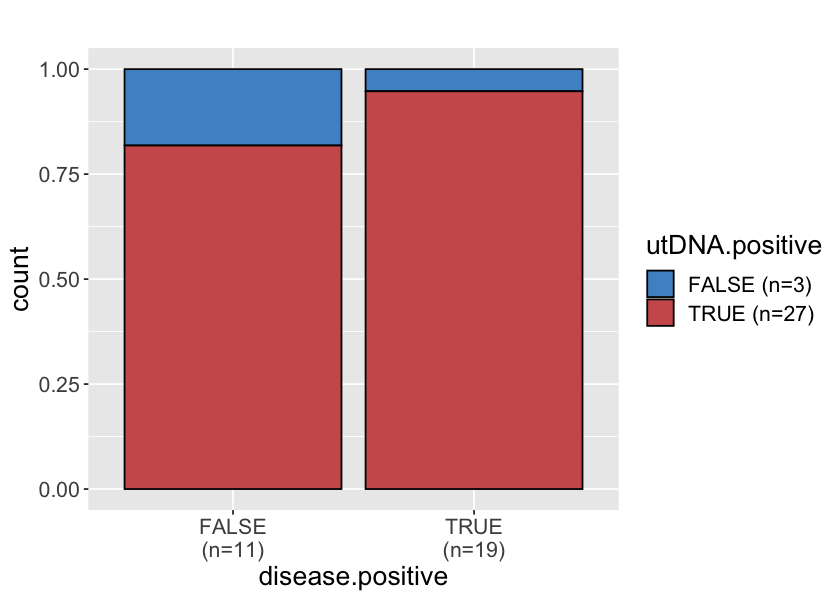

In [111]:
## correlation of mrd.status pipeline call with disease positivity

df_ngsqc.preur.index = df_ngsqc.preur %>% filter(StudyVisit.baseline=="IndexTURBT")
df_ngsqc.preur.repeat = df_ngsqc.preur %>% filter(StudyVisit.baseline=="RepeatTURBT") # remember no disease.positive=FALSE patients

source("~/Desktop/puffin/R/helper_functions.R")

options(repr.plot.width=7, repr.plot.height=5)

df_plot = 

contingency_plot(df = df_ngsqc.preur.index, x = "disease.positive", y = "utDNA.positive", 
                 y.percent = FALSE, colors = c("FALSE"="steelblue3", "TRUE"="indianred"))

In [56]:
# BEACON variants
# vars.all1 = read.csv("tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011_Variant_all_2023-11-06.csv")
# vars.all2 = read.csv("tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP001172_PRDC_MOFFITT_batch3_pre_urine_mrd/WOP01172_PRDC-MOFFITT-NMIBC-22001_Variant_all_2023-11-15.csv")
# vars.all = rbind.common(vars.all1, vars.all2) %>% mutate(PatientID=fix_PIDs(PatientID)) %>% distinct()
# table(vars.all$PatientID)
# vars.all = vars.all %>% filter(sampleNames %in% unique(df_ngsqc.preur$SampleID.sample)) %>% distinct()
# nrow(vars.all)
# write.csv(vars.all, "tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00253_254_1172_PRDC_MOFFITT_preRepeatUrine_MRD_Variant_all_11152023.csv", row.names=F)
# write.csv(vars.all, glue("data_delivery/NMIBC_BEACON_PreUR_all_variants_batch1to3_{Sys.Date()}.csv"), row.names=F)

 [1] "172851" "172586" "173983" "169558" "161922" "172530" "173362" "172229"
 [9] "173334" "171769" "175492" "152237" "177967" "173350" "175725" "171821"
[17] "174083" "182022" "174872" "175425" "176388" "175854" "175980" "173975"
[25] "173912" "176349" "174091" "176828" "180264" "172749" "175325" "173281"
[33] "173075" "116381" "167162" "175387" "175648"



116381 152237 161922 167162 169558 171769 171821 172229 172530 172586 172749 
   357    384    306    376    272    444    329    408    237    274    226 
172851 173075 173281 173334 173350 173362 173912 173975 173983 174083 174091 
   246    459    340    325    332    253    279    212    133    228    404 
174872 175325 175387 175425 175492 175648 175725 175854 175980 176349 176388 
   313    294    393    257    232    298    292    176    173    251    287 
176828 177967 180264 182022   <NA> 
   261    324    297    430      0 

[1] 8640

   disease.positive      tf.m.f
1              TRUE 0.000000000
2              TRUE 0.022549160
3             FALSE 0.003252546
4              TRUE 0.002797925
5             FALSE 0.000000000
6              TRUE 0.001755319
7             FALSE 0.000385716
8              TRUE 0.290001477
9              TRUE 0.313986973
10             TRUE 0.045817958
11             TRUE 0.041550916
12             TRUE 0.138892044
13             TRUE 0.101427597
14            FALSE 0.011361921
15             TRUE 0.054228574
16            FALSE 0.015154614
17             TRUE 0.029593661
18            FALSE 0.006525285
19             TRUE 0.209805086
20             TRUE 0.158077090
21            FALSE 0.000534279
22            FALSE 0.000000000
23            FALSE 0.001542289
24            FALSE 0.000789806
25             TRUE 0.027606516
26             TRUE 0.073988077
27             TRUE 0.137138011
28             TRUE 0.000554275
29             TRUE 0.190740220
30            FALSE 0.000434105
Complete

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 34
number of NA labels: 0
[1] "case/control: 21 / 13"


Setting levels: control = FALSE, case = TRUE



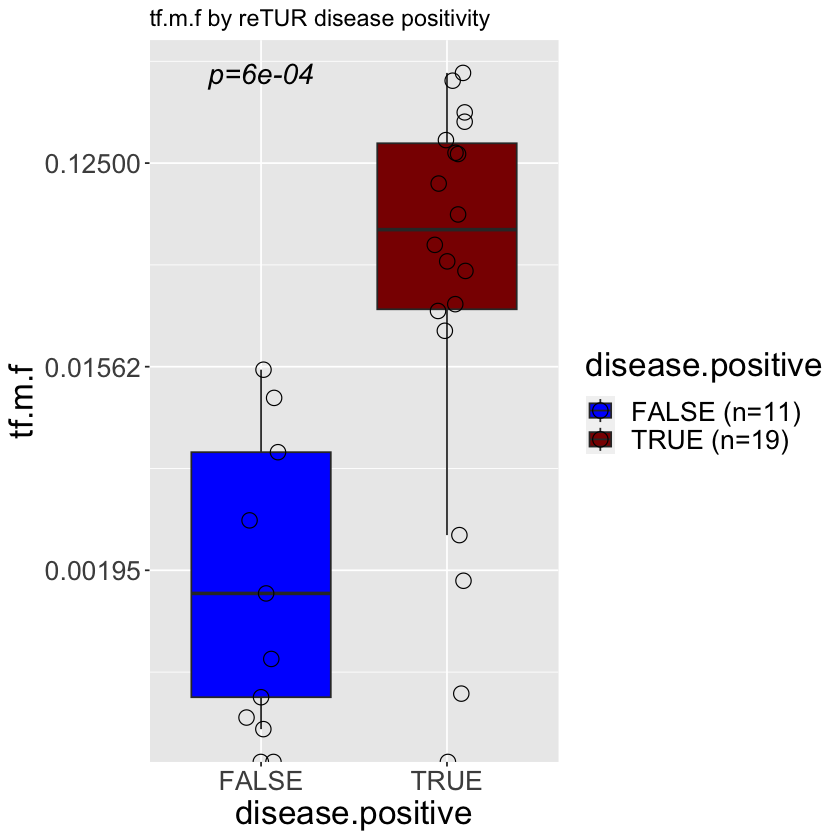

   threshold specificity sensitivity
1 0.01885189   0.9230769   0.6666667
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.758241758241758"
   disease.positive tumorFraction
1              TRUE    0.00005000
2              TRUE    0.19501000
3             FALSE    0.01781900
4              TRUE    0.01074500
5             FALSE    0.00005000
6              TRUE    0.00896220
7             FALSE    0.00033253
8              TRUE    0.53540000
9              TRUE    0.66418000
10             TRUE    0.18082000
11             TRUE    0.53142000
12             TRUE    0.80627000
13             TRUE    0.25716000
14            FALSE    0.03596200
15             TRUE    0.20326000
16            FALSE    0.06349200
17             TRUE    0.10363000
18            FALSE    0.03315900
19             TRUE    0.45183000
20             TRUE    0.37583000
21            FALSE    0.00048459
22            FALSE    0.00005000
23            FALSE    

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 26
number of NA labels: 0
[1] "case/control: 21 / 13"


Setting levels: control = FALSE, case = TRUE



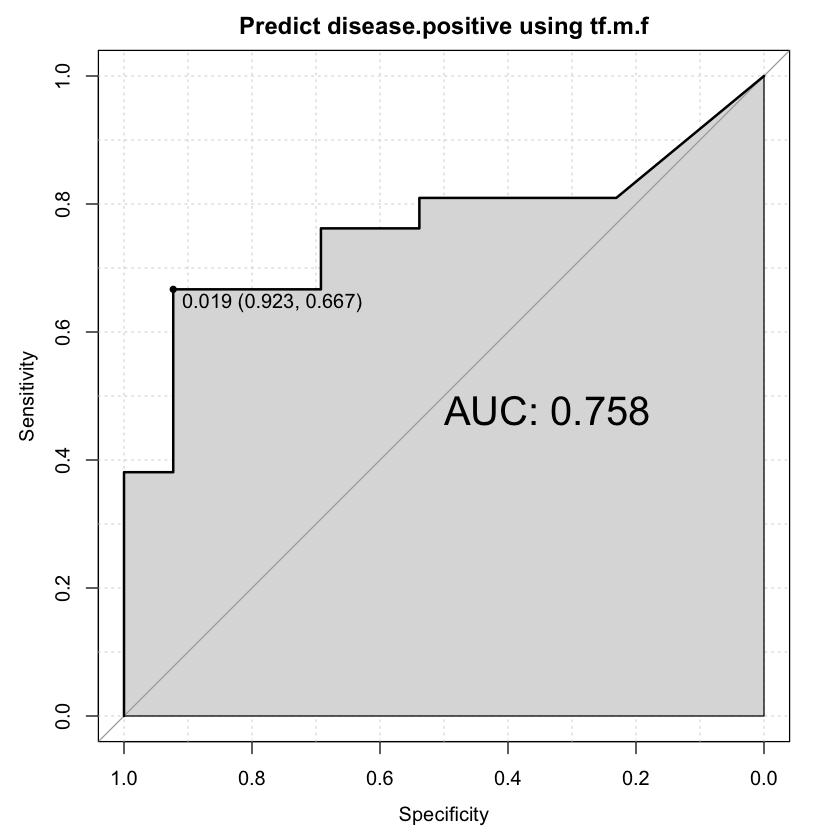

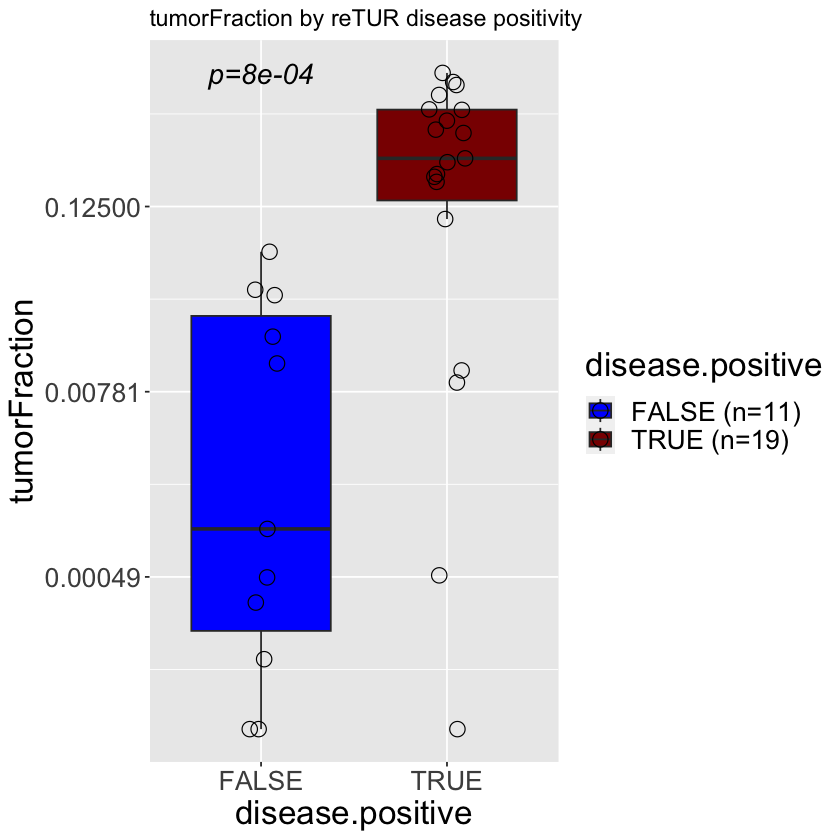

  threshold specificity sensitivity
1 0.0607245           1        0.65
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.816666666666667"
   disease.positive mutationCount
1              TRUE             1
2              TRUE            38
3             FALSE            34
4              TRUE            76
5             FALSE            22
6              TRUE            20
7             FALSE            49
8              TRUE            35
9              TRUE            65
10             TRUE            49
11             TRUE            53
12             TRUE            28
13             TRUE            20
14            FALSE            63
15             TRUE            49
16            FALSE            46
17             TRUE            36
18            FALSE             5
19             TRUE             6
20             TRUE            29
21            FALSE            53
22            FALSE            36
23            FALSE      

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 34
number of NA labels: 0
[1] "case/control: 21 / 13"


Setting levels: control = FALSE, case = TRUE



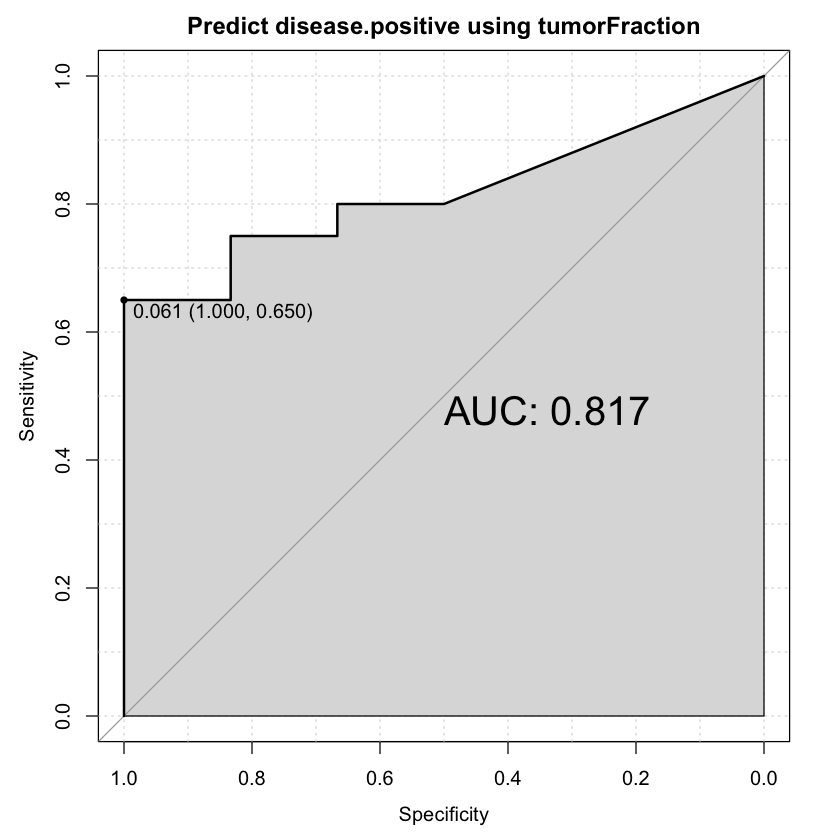

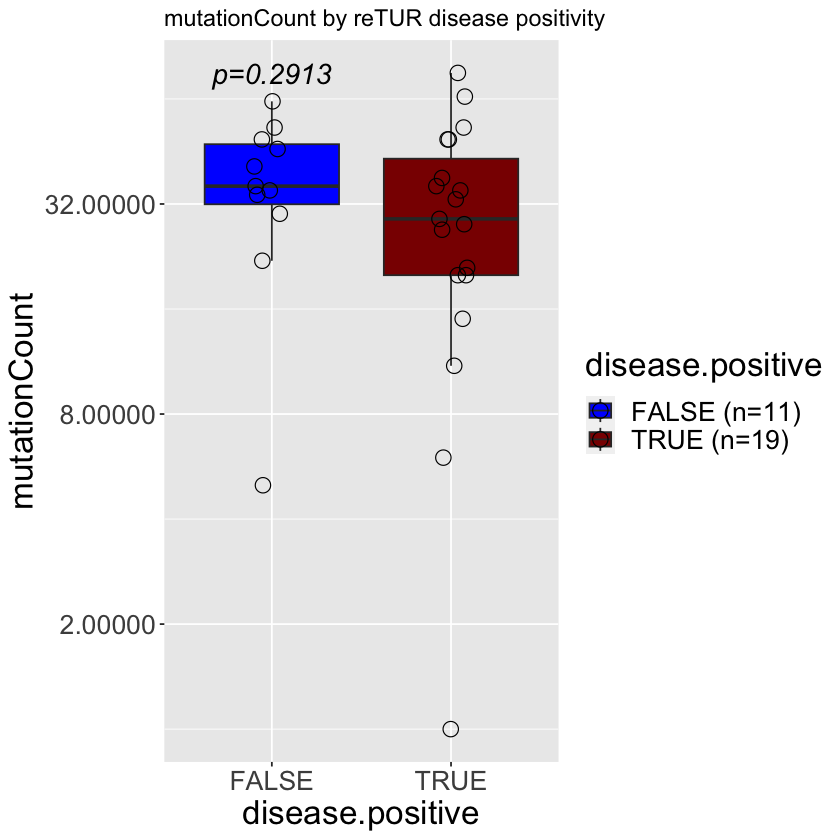

  threshold specificity sensitivity
1        64           1   0.0952381
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.371794871794872"
   disease.positive mutationCount.mrd
1              TRUE                 1
2              TRUE                36
3             FALSE                33
4              TRUE                73
5             FALSE                16
6              TRUE                 7
7             FALSE                43
8              TRUE                31
9              TRUE                62
10             TRUE                42
11             TRUE                45
12             TRUE                11
13             TRUE                14
14            FALSE                60
15             TRUE                41
16            FALSE                31
17             TRUE                35
18            FALSE                 2
19             TRUE                 3
20             TRUE                20
21       

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 34
number of NA labels: 0
[1] "case/control: 21 / 13"


Setting levels: control = FALSE, case = TRUE



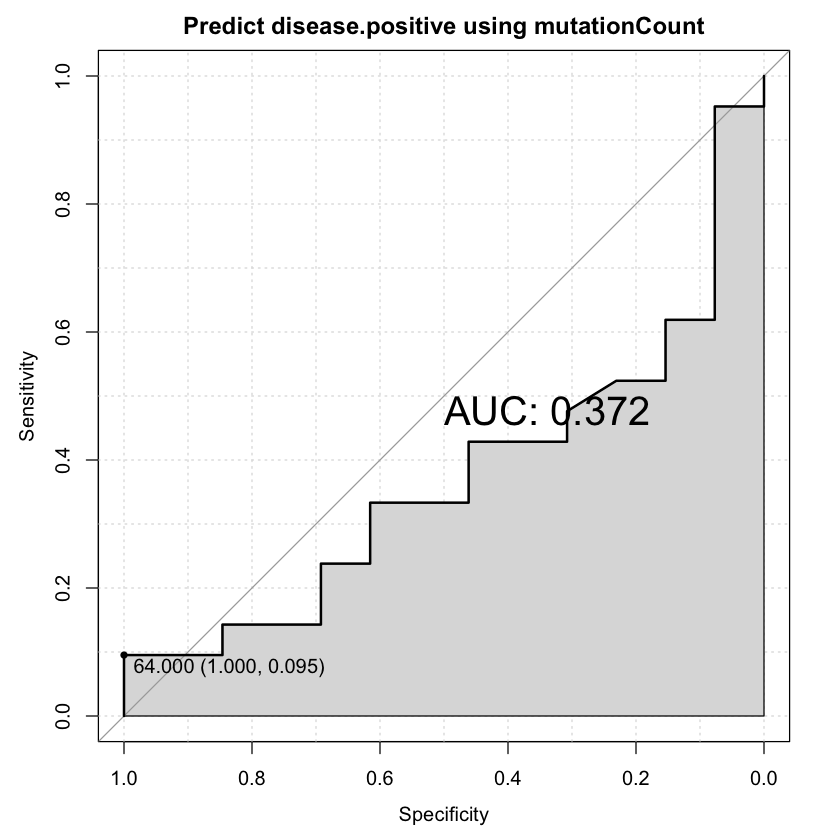

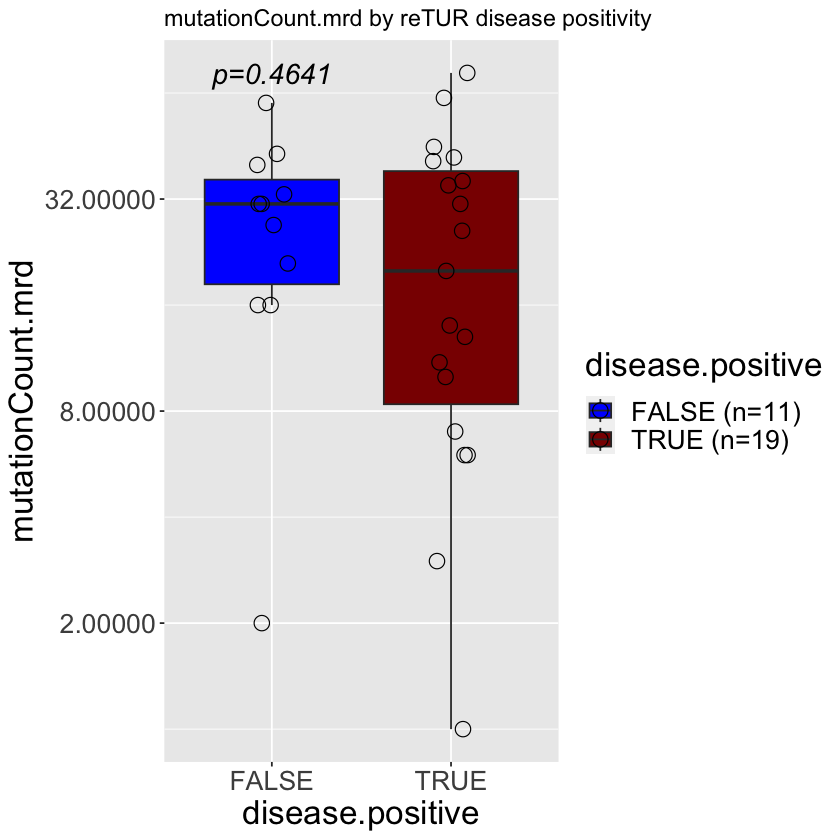

  threshold specificity sensitivity
1      60.5           1   0.0952381
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.382783882783883"
   disease.positive mutationCount.mrd.f
1              TRUE                   1
2              TRUE                  36
3             FALSE                  31
4              TRUE                  70
5             FALSE                   6
6              TRUE                   7
7             FALSE                  34
8              TRUE                  31
9              TRUE                  62
10             TRUE                  42
11             TRUE                  45
12             TRUE                  10
13             TRUE                  15
14            FALSE                  60
15             TRUE                  42
16            FALSE                  26
17             TRUE                  35
18            FALSE                   4
19             TRUE                   4
20     

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 34
number of NA labels: 0
[1] "case/control: 21 / 13"


Setting levels: control = FALSE, case = TRUE



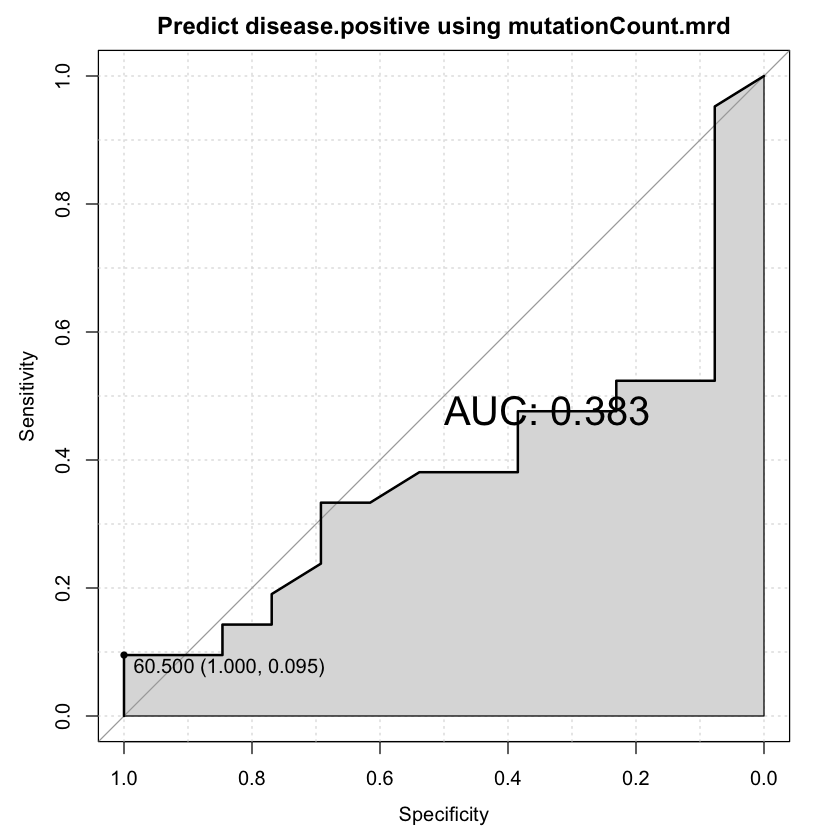

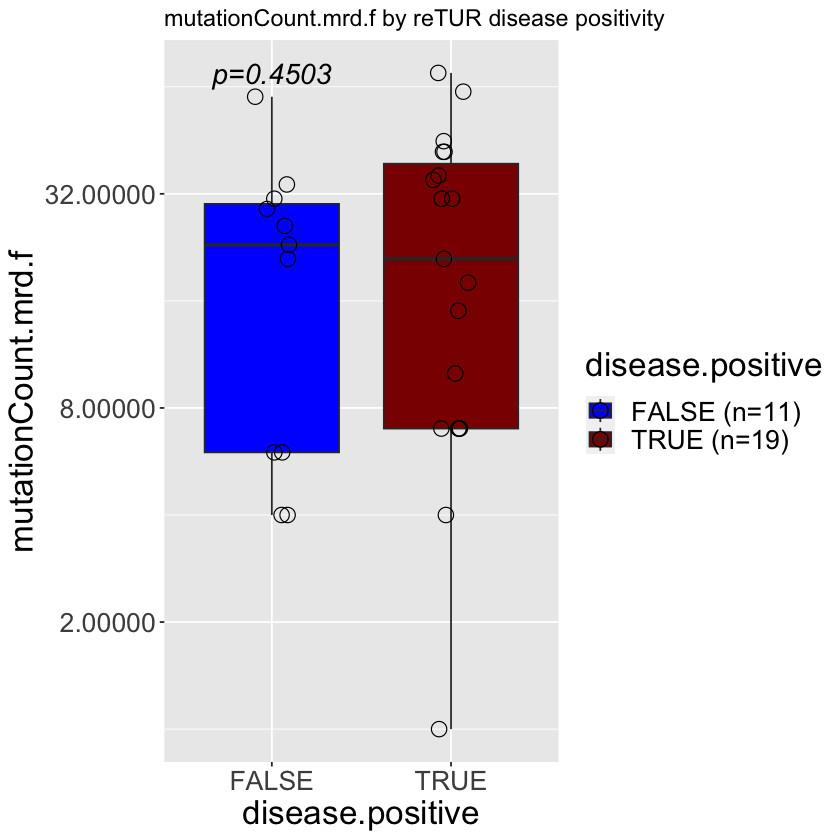

  threshold specificity sensitivity
1        35   0.9230769   0.2857143
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.510989010989011"
   disease.positive mrd.score
1              TRUE     0.000
2              TRUE    31.625
3             FALSE    16.025
4              TRUE    60.800
5             FALSE     0.475
6              TRUE     6.125
7             FALSE     9.600
8              TRUE    38.875
9              TRUE    56.250
10             TRUE    42.225
11             TRUE    45.250
12             TRUE     6.300
13             TRUE    11.500
14            FALSE    60.125
15             TRUE    42.975
16            FALSE    19.950
17             TRUE    34.000
18            FALSE     2.250
19             TRUE     4.750
20             TRUE    22.875
21            FALSE    12.925
22            FALSE     1.475
23            FALSE    13.151
24            FALSE    12.354
25             TRUE     5.125
26             TRUE    31.0

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 34
number of NA labels: 0
[1] "case/control: 21 / 13"


Setting levels: control = FALSE, case = TRUE



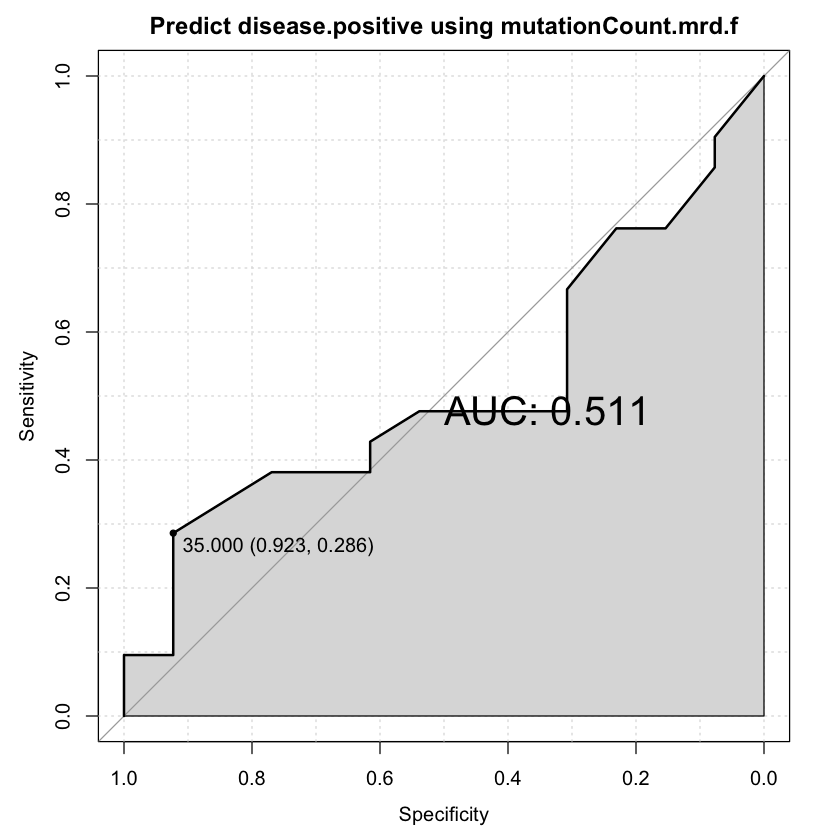

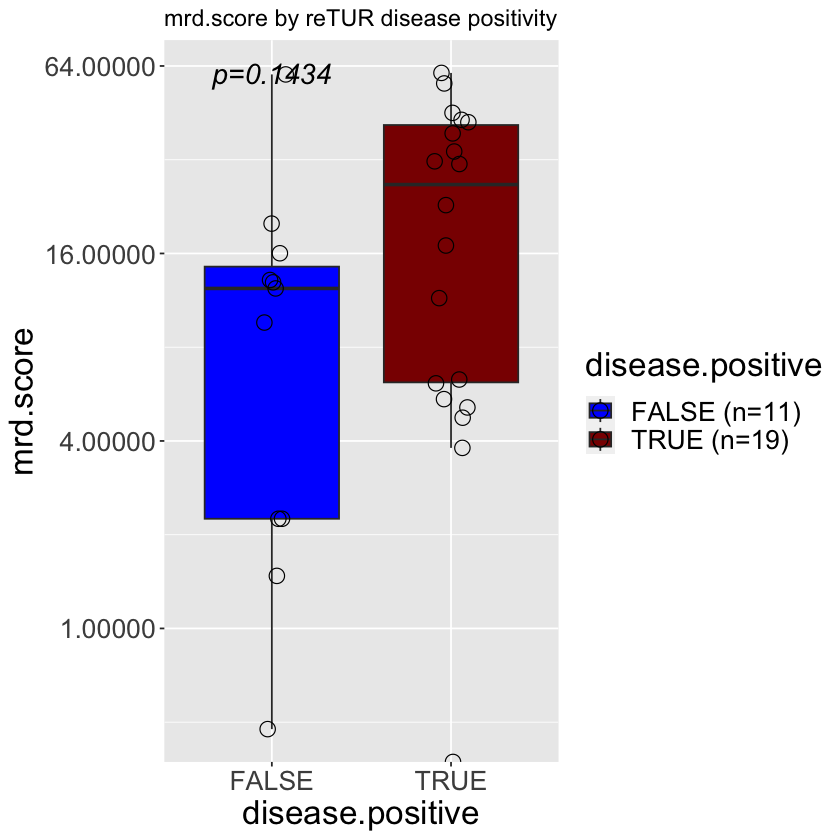

  threshold specificity sensitivity
1    26.625   0.9230769   0.4761905
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.564102564102564"
   disease.positive wgsTumorfrac_ichorCNA
1              TRUE                0.0259
2              TRUE                0.0000
3             FALSE                0.0000
4              TRUE                0.0000
5             FALSE                0.0000
6              TRUE                0.1427
7             FALSE                0.0000
8              TRUE                0.1260
9              TRUE                0.1826
10             TRUE                0.0259
11             TRUE                0.0266
12             TRUE                0.2441
13             TRUE                0.0354
14            FALSE                0.0000
15             TRUE                0.0265
16            FALSE                0.0163
17             TRUE                0.0240
18            FALSE                0.0000
19       

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 29
number of NA labels: 0
[1] "case/control: 19 / 11"


Setting levels: control = FALSE, case = TRUE



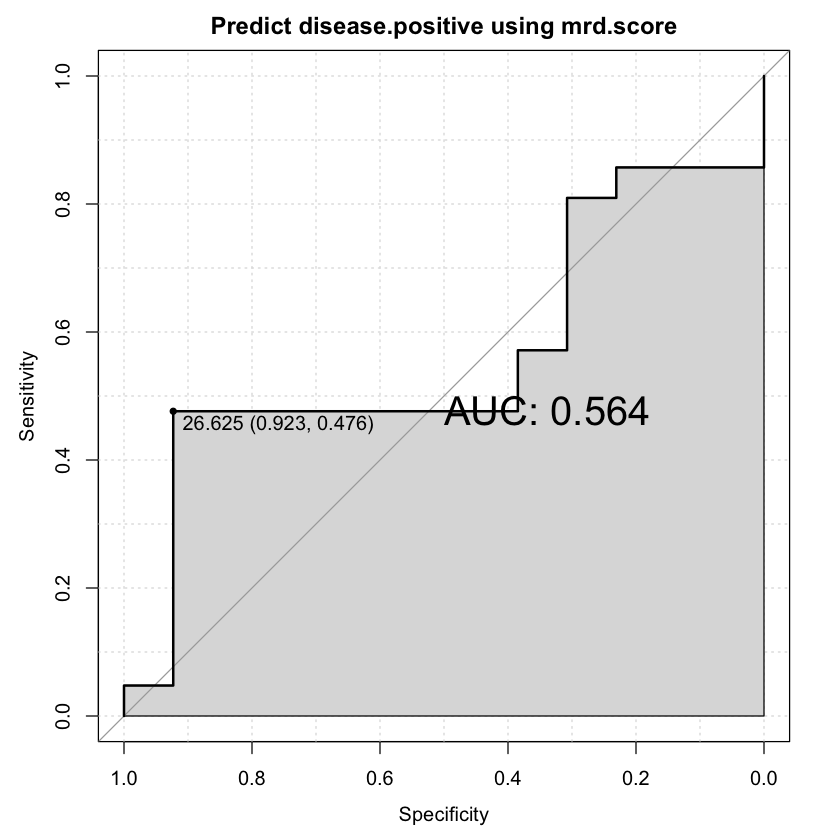

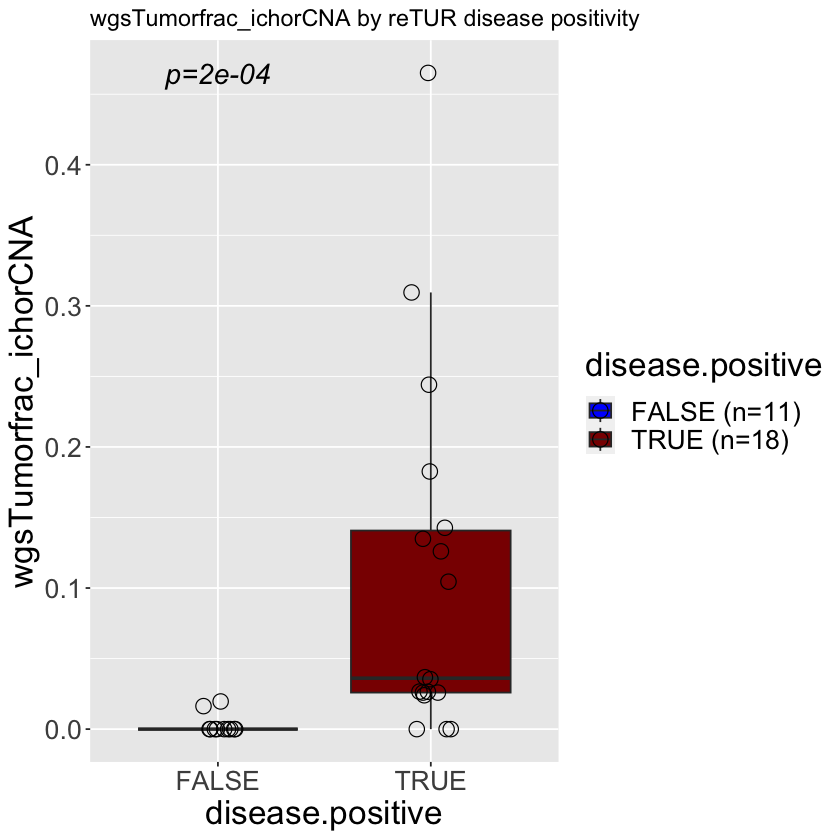

  threshold specificity sensitivity
1    0.0218           1   0.8333333
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.901515151515152"
   disease.positive  cnbScore
1              TRUE  5.298889
2              TRUE  5.685603
3             FALSE  3.564916
4              TRUE  3.521956
5             FALSE  3.318286
6              TRUE  9.686186
7             FALSE  4.023014
8              TRUE  9.327906
9              TRUE  9.270623
10             TRUE  6.529883
11             TRUE  6.694965
12             TRUE 10.356708
13             TRUE  7.482852
14            FALSE  5.257362
15             TRUE  7.336440
16            FALSE  5.928365
17             TRUE  5.796174
18            FALSE  5.655735
19             TRUE 10.622267
20             TRUE  8.836156
21            FALSE  3.727785
22            FALSE  3.885706
23            FALSE  3.233484
24            FALSE  3.372820
25             TRUE  9.748165
26             TRUE  7.4603

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 29
number of NA labels: 0
[1] "case/control: 19 / 11"


Setting levels: control = FALSE, case = TRUE



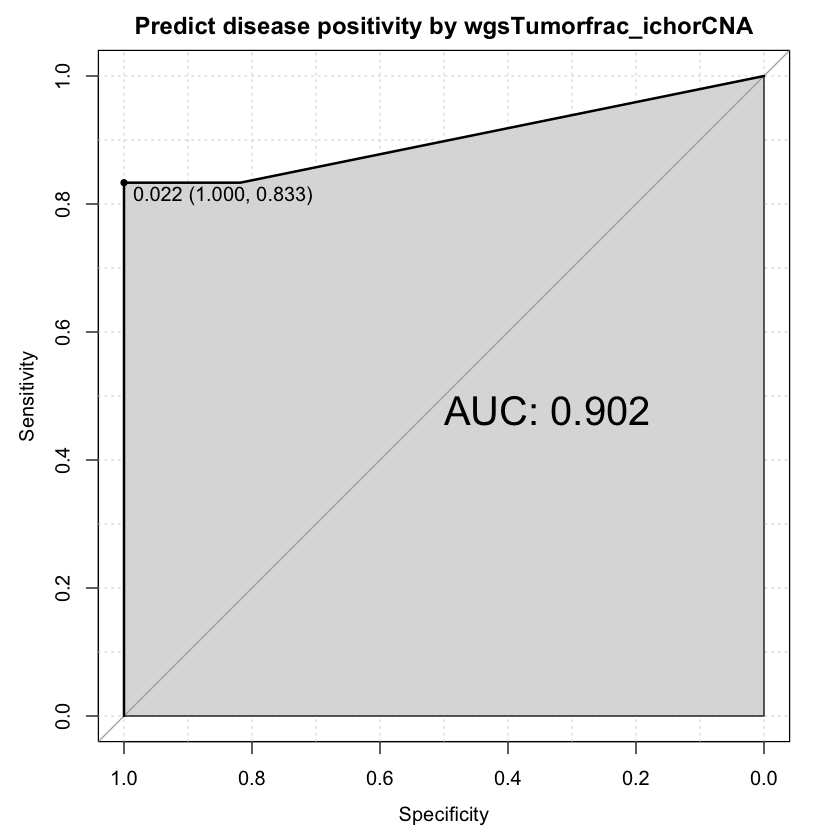

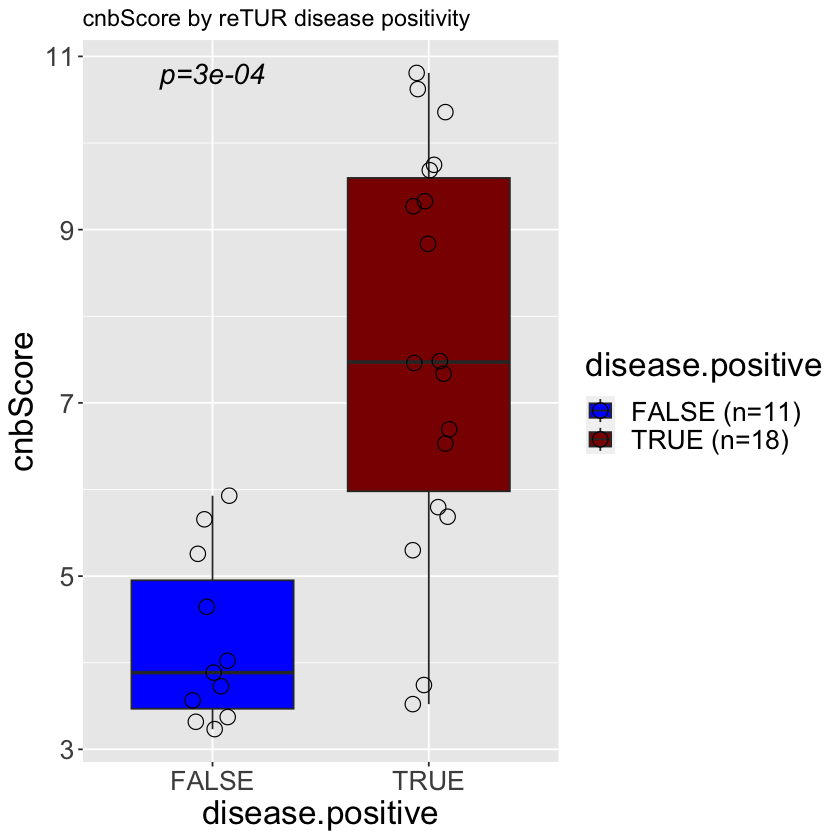

  threshold specificity sensitivity
1  5.670669   0.9090909   0.8333333
[1] "target sens 1"
  threshold specificity sensitivity
1  3.447388   0.2727273           1
[1] "AUC: 0.909090909090909"


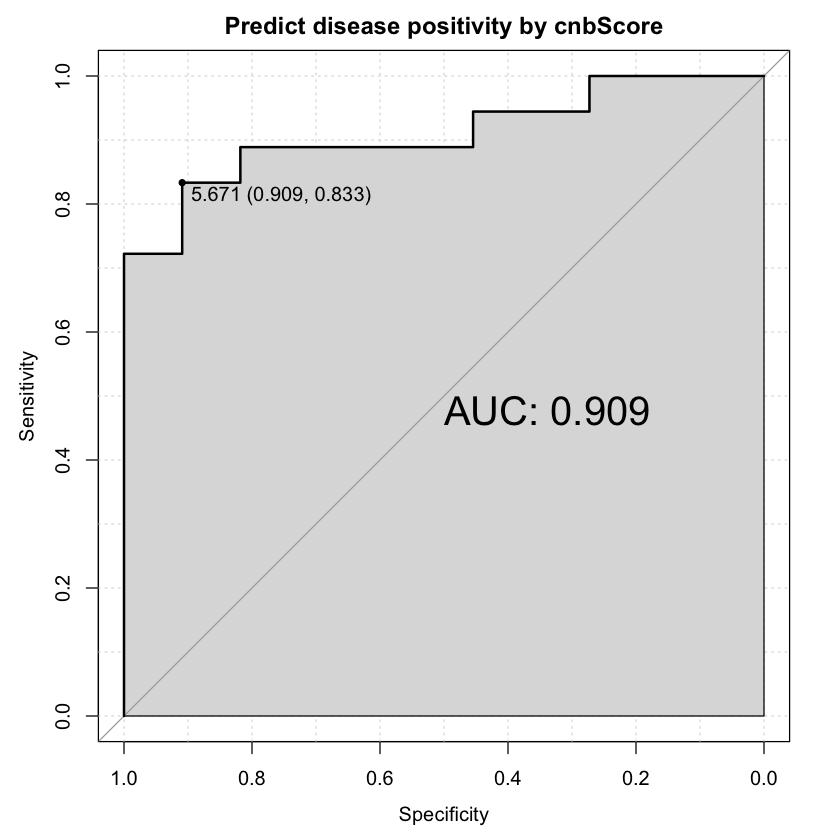

In [112]:
# correlation of MRD tumor fraction with disease positivity and prediction AUCs
source("~/Desktop/puffin/R/helper_functions.R")

df_ngsqc.preur.index = df_ngsqc.preur %>% filter(StudyVisit.baseline=="IndexTURBT")
df_ngsqc.preur.repeat = df_ngsqc.preur %>% filter(StudyVisit.baseline=="RepeatTURBT")

df = df_ngsqc.preur.index

#pdf("./tissue_probe_mrd/pre_repeat_urine_MRD_all/NMIBC_preUR_TF_IndexBaseline_boxplot_11162023.pdf", onefile = TRUE)

options(repr.plot.width=7, repr.plot.height=7)
for (stat in c('tf.m.f',
    'tumorFraction','mutationCount','mutationCount.mrd','mutationCount.mrd.f',
    'mrd.score'
              )){   
    g <- quick_boxplot(df, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = TRUE, log.0.adj=0.00001, plot.title = glue("{stat} by reTUR disease positivity"),
                       #label.col="PatientID"
                      )
    show(g)
    get_sens_spec(df.auc, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease.positive using {stat}"))
}
#dev.off()

# correlation of LPWGS with disease positivity and prediction AUCs
for (stat in c('wgsTumorfrac_ichorCNA', 'cnbScore'#, 'wgsTumorfrac_EM'
              )){
    g <- quick_boxplot(df, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = FALSE, plot.title = glue("{stat} by reTUR disease positivity"),
                       #pt.label="PatientID"
                      )
    show(g)
    get_sens_spec(df, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
}
#dev.off()

In [336]:
## AUA stats for 34 patients
median(df_ngsqc.preur$wgsTumorfrac_ichorCNA[df_ngsqc.preur$disease.positive=="TRUE"], na.rm=T)
median(df_ngsqc.preur$wgsTumorfrac_ichorCNA[df_ngsqc.preur$disease.positive=="FALSE"], na.rm=T)

median(df_ngsqc.preur$tumorFraction[df_ngsqc.preur$disease.positive=="TRUE"], na.rm=T)
median(df_ngsqc.preur$tumorFraction[df_ngsqc.preur$disease.positive=="FALSE"], na.rm=T)

[1] NA

[1] NA

[1] NA

[1] NA

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


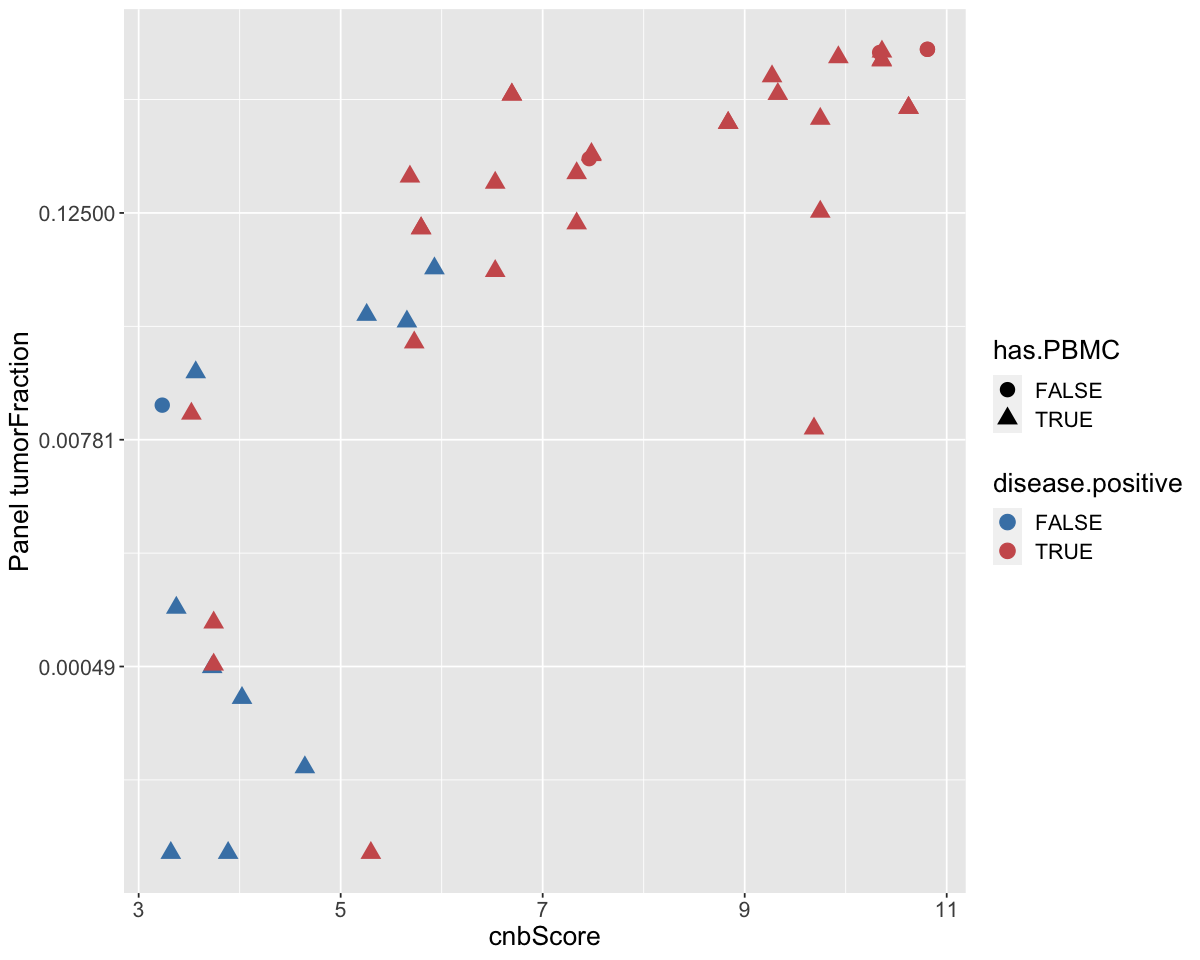

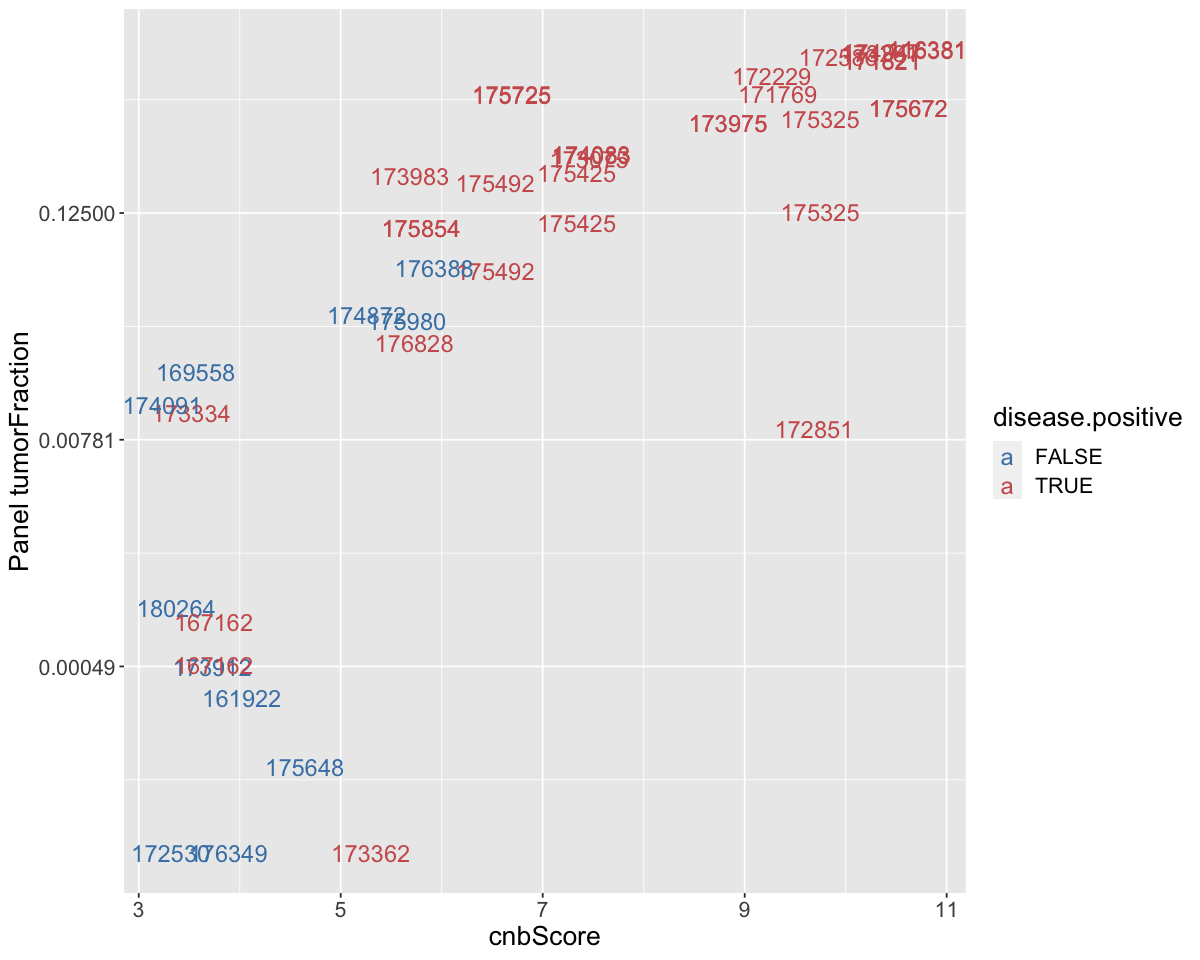

In [113]:
#pdf("./tissue_probe_mrd/pre_repeat_urine_MRD_all/NMIBC_PreRepeatUrine_LPvsPanel_scatter_11072023.pdf", # rerun
#    width=9,height=7, onefile=TRUE)

#pat.colors = get_random_color_dict(df_ngsqc.urine.mrd$PatientID)

# 3 patients LPWGS Fail

scaleFUN <- function(x) sprintf("%.5f", x)
options(repr.plot.width=10, repr.plot.height=8)
ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction, color=disease.positive, shape=has.PBMC)) + 
    geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    #scale_x_discrete(labels=c("TRUE \nN=20", "FALSE\nN=12")) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")

ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction, color=disease.positive, label=PatientID
                              )) + 
    #geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    geom_text(check_overlap = FALSE, position=position_jitter(),size=5) +
    #scale_color_manual(values=pat.colors) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")
#dev.off()

# Methylation for preRepeat MRD 

In [244]:
# df_ngsqc.preur = read.csv("./tissue_probe_mrd/tmp_mrd_data_set.csv")
# head(df_ngsqc.preur)

# df_lpwgs_all = read.csv("./tissue_probe_mrd/LPWGS_data_all_11062023.csv")
# head(df_lpwgs_all)

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline,has.PBMC,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,wgsTumorfrac_EM
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<lgl>,<int>,<chr>,<int>,<int>,<lgl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,P219768,P220082,5,5,73,1,1,1,0.000,0.000,FALSE,TRUE,0,0.0005111168,0.000000e+00,0.000000e+00,0.04111842,0.27262814,6.7612,0.28133,0.28133,0.000000e+00,0.001874776,0.000000e+00,0.000000e+00,0.0000e+00,0.000000e+00,P219768,Pre-RepeatTURBT,173362,NA,173362,IndexTURBT,173362,173362,TRUE,0.0259,60.137,1843520,5.298889,0.0000000
2,P217592,P220085,36,36,0,38,36,36,30.125,31.625,TRUE,TRUE,1,0.0225491599,1.627251e-02,1.338526e-02,10.80395545,0.09633794,51.9150,0.68347,0.68347,1.689107e-01,0.234063133,1.389407e-01,9.496180e-02,1.9501e-01,1.950103e-01,P217592,Pre-RepeatTURBT,173983,NA,173983,IndexTURBT,173983,173983,TRUE,0.0000,55.043,2358302,5.685603,0.0000000
3,P217594,P220073,34,34,0,34,33,31,16.025,16.025,TRUE,TRUE,0,0.0032525463,1.770314e-03,1.336200e-03,0.89898273,0.07938568,23.4690,0.26590,0.26590,2.230017e-02,0.040971448,1.683176e-02,4.475564e-03,1.7819e-02,1.781946e-02,P217594,Pre-RepeatTURBT,169558,NA,169558,IndexTURBT,169558,169558,TRUE,0.0000,23.266,1936359,3.564916,0.0000000
4,P219771,P220076,79,78,1,76,73,70,59.800,60.800,TRUE,TRUE,1,0.0027979252,2.641349e-03,1.420949e-03,0.54013783,0.20652446,59.8930,0.66059,0.66059,1.278952e-02,0.013547670,6.880296e-03,4.545054e-03,1.0745e-02,1.074472e-02,P219771,Pre-RepeatTURBT,173334,NA,173334,IndexTURBT,173334,173334,TRUE,0.0000,22.463,2382513,3.521956,0.0000000
5,P217596,P220079,68,64,4,22,16,6,0.475,0.475,FALSE,TRUE,0,0.0002495944,7.060887e-06,7.060887e-06,0.04056795,0.13272485,19.9300,0.34690,0.34690,5.319944e-05,0.001880540,5.319944e-05,1.845488e-05,1.8455e-05,1.845488e-05,P217596,Pre-RepeatTURBT,172530,NA,172530,IndexTURBT,172530,172530,TRUE,0.0000,16.653,2134340,3.318286,0.0000000
6,P217590,P220074,40,21,40,20,7,7,6.125,6.125,TRUE,TRUE,0,0.0017553191,1.625665e-03,1.625665e-03,0.45012604,0.26793088,17.6140,0.67709,0.29952,6.067479e-03,0.006551388,6.067479e-03,1.817331e-03,8.9622e-03,8.962180e-03,P217590,Pre-RepeatTURBT,172851,NA,172851,IndexTURBT,172851,172851,TRUE,0.1427,812.660,2015010,9.686186,0.4306547


,SampleID,Total.reads..M.,Mapped.reads..M.,Mapping.rate....,Consensus.reads..M.,Duplication.rate....,Fragment_Size_Mode,Softclip.ratio,ProjectDir,coveredGenomicPect,coverage,qcLabel,gender,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,classificationLabel,binNum,cnvbinNum,cnabinNum,cnlbinNum,cnvbinRatio,neutbinNum,neutbinRatio,wgsTumorfrac_EM,externalSampleID,SampleID.short,SampleType,StudyVisit,PatientID,disease.positive
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>
1,P220068_WGS,1190,1180,99.5,647,45.2,157,0.985,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.1,26.84,Pass,female,0.1273,992.271,26924036,10.046665,highRisk,2442,1321,838,483,0.541,412,0.169,0.3592600,06S22068061,P220068,Tissue,IndexTURBT,172229,TRUE
2,P220069_WGS,1210,1200,99.7,623,48.2,147,0.530,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,24.92,Pass,male,0.3867,1884.494,26393139,11.002190,highRisk,2441,1330,430,900,0.545,1078,0.442,0.4733614,06S22035975,P220069,Tissue,IndexTURBT,172586,TRUE
3,P220070_WGS,1200,1190,99.7,650,45.5,180,0.366,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,31.19,Pass,male,0.2390,1258.305,31753729,10.415608,highRisk,2442,1321,599,722,0.541,1062,0.435,0.2534166,06S22052895,P220070,Tissue,RepeatTURBT,172586,TRUE
4,P220073_WGS,973,970,99.6,538,44.5,179,0.429,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,26.80,Pass,male,0.0242,163.316,27302368,7.340233,highRisk,2442,242,92,150,0.099,318,0.130,0.1063838,06S22052894,P220073,Tissue,IndexTURBT,169558,FALSE
5,P220074_WGS,1260,1260,99.7,662,47.4,179,0.408,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,32.62,Pass,male,0.1193,983.514,33927666,9.880656,highRisk,2442,1405,783,622,0.575,488,0.200,0.2080755,06S22036104,P220074,Tissue,IndexTURBT,172851,TRUE
6,P220075_WGS,1140,1130,99.7,630,44.3,183,0.633,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,30.20,Pass,male,0.1407,1200.872,30989435,10.299508,highRisk,2442,1675,814,861,0.686,568,0.233,0.2215777,06S22052897,P220075,Tissue,RepeatTURBT,172851,TRUE


In [332]:
## methyl data

# old methyl data for pre- and post- op urine samples from batch 1+2
# methyl.data1n2 = standardize_names(read_excel("./Methylation_data/batch1n2/region_summary_info_batch1n2.xlsx", sheet="in") %>%
#                                                 mutate(SampleID = Sample.Name)  %>% slice_head(n=44),
#                                    sid.format = "remove.suffix", input.type="samples") %>%
#                 select(-SampleType) %>%
#                 left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short")
# #warn_na(methyl.data1n2$SampleType)
#table(methyl.data1n2$SampleType, methyl.data1n2$StudyVisit)
methyl.data = read.csv("./Methylation_data/Nov_6_2023/PRDC-MOFFITT-NMIBC-22001_165_samples_Methylation_summary_info_11082023.csv") # missing batch 3 and 4 urine samples
methyl.data = standardize_names(methyl.data %>% mutate(SampleID=Sample.Name) %>% slice_head(n=165),
                                sid.format = "remove.suffix", input.type="samples") %>%
                select(-SampleType) %>%
                mutate(PatientID=fix_PIDs(SubjectID)) %>%
                left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short")
names(methyl.data)
#write.csv(methyl.data, "./Methylation_data/Nov_6_2023/region_summary_for_client_formatted.csv", row.names=F)
#stop()

#warn_na(methyl.data3n4$SampleType)
#table(methyl.data3n4$SampleType, methyl.data1n2$StudyVisit)
# methyl.data = rbind.common(methyl.data1n2, methyl.data3n4) %>%
#                     mutate(PatientID = fix_PIDs(SubjectID))

methyl.data = methyl.data %>% left_join(df_clin %>% select(PatientID, disease.positive), by="PatientID") %>%
                    mutate(SampleType=ifelse(is.na(SampleType), "Tissue", SampleType), # missing sampletype for benign urotheils
                           disease.positive = factor(disease.positive, levels=c("FALSE","TRUE")))

table(methyl.data$StudyVisit, methyl.data$SampleType)
#head(methyl.data)
#write.csv(methyl.data, "./Methylation_data/all_methyl_data_NMIBC_11062023.csv", row.names=F)

methyl.data.preur = methyl.data %>% filter(StudyVisit=="Pre-Repeat TURBT", 
                                           SampleType == "Urine",
                                           #PatientID %in% pre.urine.mrd.patients # add batch 4 patients
                                          )
table(methyl.data.preur$PatientID)

for (stat in c("filtered_total_abnormal_regions_per_sample",
               "filtered_total_abnormal_frags_per_sample")){
    
    options(repr.plot.width=8, repr.plot.height=5)
    g <- quick_boxplot(methyl.data.preur, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = TRUE, plot.title = glue("{stat} by reTUR disease positivity"))
    show(g)
    
    options(repr.plot.width=7, repr.plot.height=7)
    get_sens_spec(methyl.data.preur, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
    }
    
###
# df_ngsqc.preur = df_ngsqc.preur %>% left_join(methyl.data %>% select(-StudyVisit,-SubjectID,-ExternalID),
#                                                        by="SampleID.short")

## does methyl in preUR predict disease

SampleID.short format: remove.suffix


Standardize.names WARN:Fill all with NA for SampleType



 [1] "116381" "152237" "161922" "165028" "167162" "169558" "171374" "171769"
 [9] "171821" "172153" "172229" "172530" "172586" "172602" "172749" "172851"
[17] "173281" "173334" "173350" "173362" "173509" "173912" "173975" "173983"
[25] "174083" "174091" "174872" "174947" "175325" "175387" "175425" "175492"
[33] "175526" "175610" "175648" "175672" "175725" "175733" "175854" "175980"
[41] "176349" "176388" "176828" "176992" "177967" "178886" "180264" "182022"
[49] "173359"


[1] "SubjectID"                                 
 [2] "StudyVisit"                                
 [3] "ExternalID"                                
 [4] "Sample.Name"                               
 [5] "total_abnormal_regions_per_sample"         
 [6] "total_abnormal_frags_per_sample"           
 [7] "filtered_total_abnormal_regions_per_sample"
 [8] "filtered_total_abnormal_frags_per_sample"  
 [9] "SampleID"                                  
[10] "SampleID.short"                            
[11] "PatientID"                                 
[12] "SampleType"

ERROR: Error in eval(expr, envir, enclos): 


[1] 49

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34



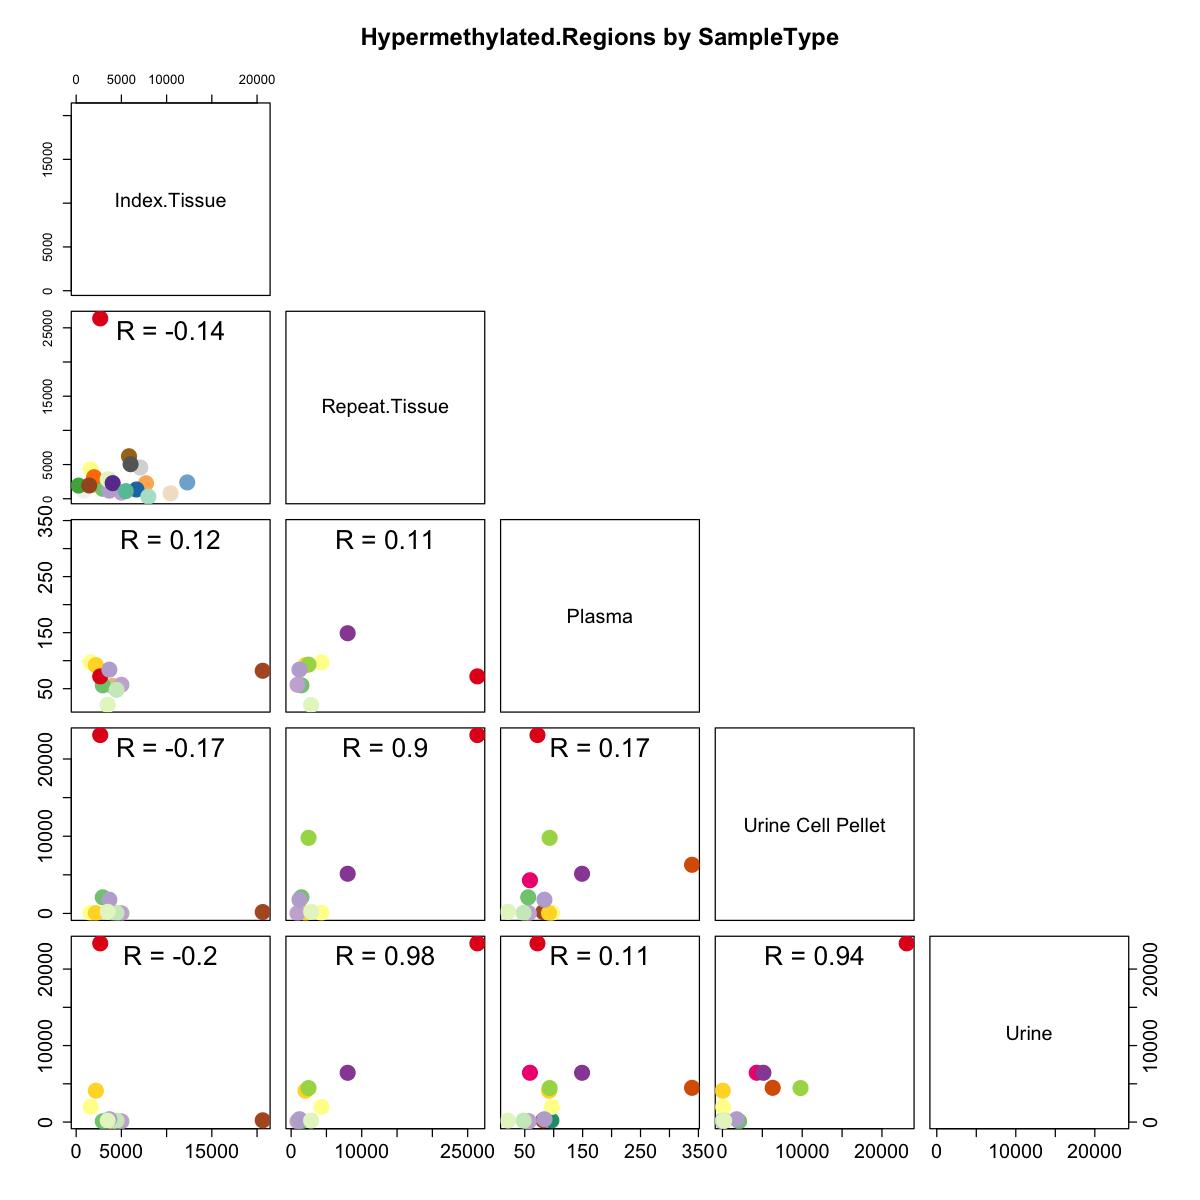


 Index.Tissue        Plasma Repeat.Tissue         Urine          <NA> 
           41            15            28            15             0 

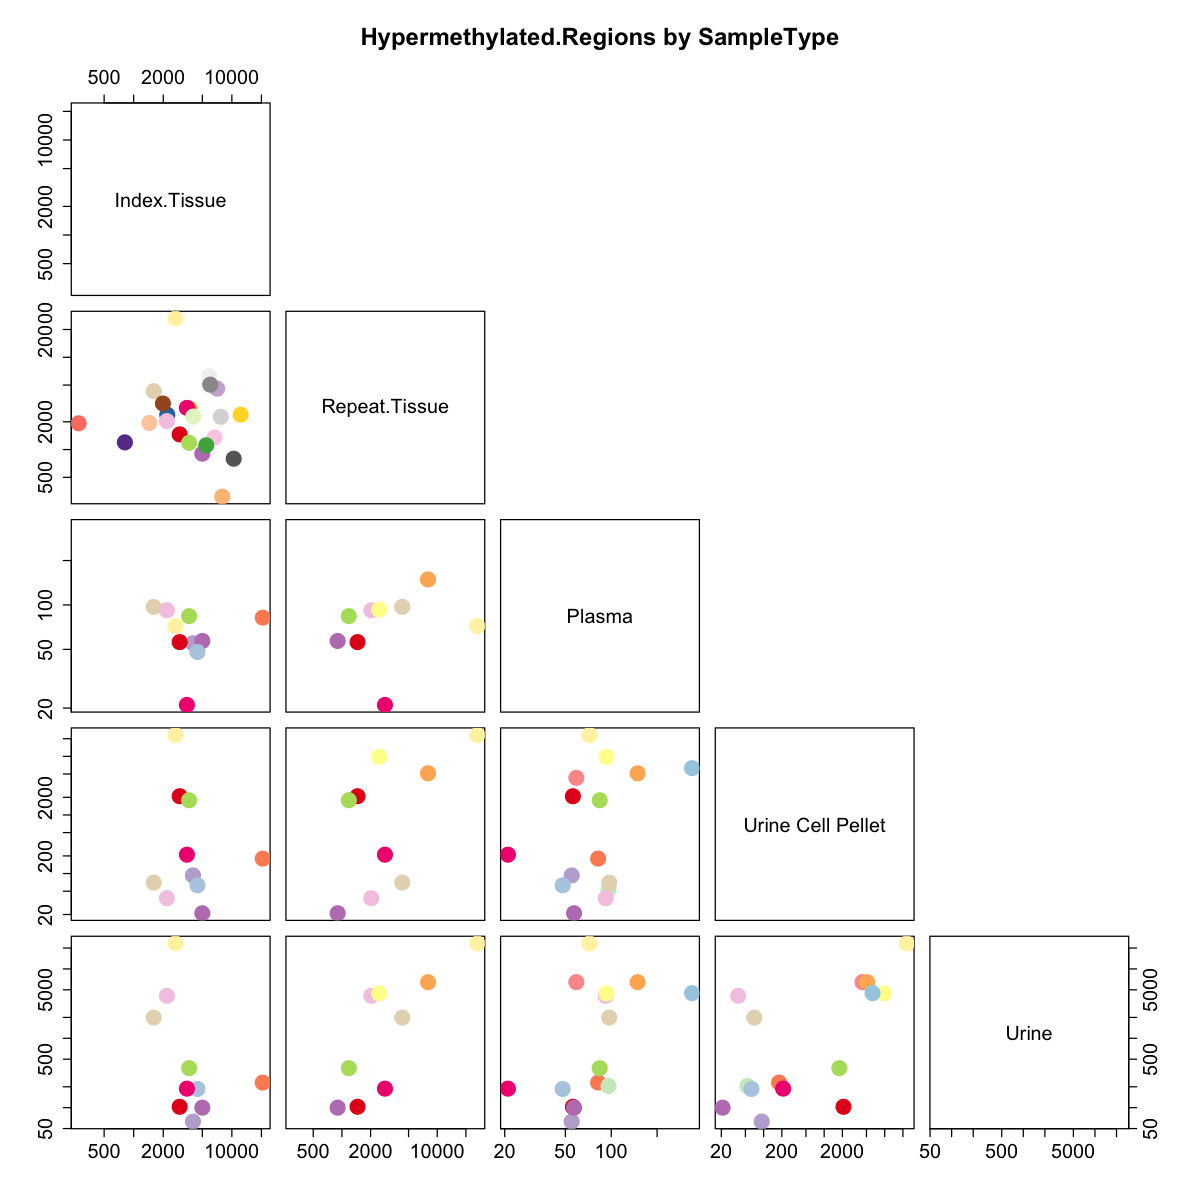

In [330]:
source("~/Desktop/puffin/R/plotFunctions.R")
# pairs plots
# is methyl in index or repeat correlated with preUR
# how does PBMC data help us?
# corr urine vs plasma vs. ucp vs. tissue
# benign vs cancer patterns?
# methyl vs lpwgs?
df_plot = methyl.data %>% 
            filter(StudyVisit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                  SampleType %in% c("Tissue","Urine","Plasma", "Urine Cell Pellet")) %>%
            mutate(SampleType=ifelse(StudyVisit=="IndexTURBT", "Index.Tissue",
                                        ifelse(StudyVisit=="RepeatTURBT", "Repeat.Tissue", SampleType))) %>%
            rename("Hypermethylated.Regions"="filtered_total_abnormal_regions_per_sample") %>% 
            select(PatientID, StudyVisit, Hypermethylated.Regions, SampleType) %>%
            pivot_wider(id_cols = "PatientID", names_from = "SampleType", names_sep = ".",values_from = "Hypermethylated.Regions")
nrow(df_plot) #49 patients
warn_na(df_plot)
options(repr.plot.width=10, repr.plot.height=10)
plt <- pairs_(df_plot, cols = names(df_plot), 
              color.by = "PatientID", log.scale=FALSE,
              legend = FALSE, plot.title="Hypermethylated.Regions by SampleType")
plt <- pairs_(df_plot, cols = names(df_plot), 
              color.by = "PatientID", log.scale=TRUE,
              legend = FALSE, plot.title="Hypermethylated.Regions by SampleType")

df_count = methyl.data %>% 
            filter(StudyVisit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                  SampleType %in% c("Tissue","Urine","Plasma")) %>%
            mutate(SampleType=ifelse(StudyVisit=="IndexTURBT", "Index.Tissue",
                                        ifelse(StudyVisit=="RepeatTURBT", "Repeat.Tissue", SampleType))) %>%
            rename("Hypermethylated.Regions"="filtered_total_abnormal_regions_per_sample") %>% 
            select(PatientID, StudyVisit, Hypermethylated.Regions, SampleType)
     
table(df_count$SampleType)

,subject_id,study_visit,external_ID,requisition_ID,chr,start,end,width,mean_fragment_beta,abnormal_fragments,log10_p.value,gene_symbol,annotation_type,CGI_overlap,CpG_num,TSS_dist,nearest_transcript,transcript_overlap
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<lgl>,<int>,<int>,<chr>,<lgl>
1,116381,IndexTURBT,06S23005718,P228837_M,chr1,975335,975586,251,0.74,6,18,AGRN,hg19_genes_introns,TRUE,15,19833,uc001ack.2,TRUE
2,116381,IndexTURBT,06S23005718,P228837_M,chr1,975586,975837,251,0.88,5,15,AGRN,hg19_genes_introns,TRUE,19,20084,uc001ack.2,TRUE
3,116381,IndexTURBT,06S23005718,P228837_M,chr1,1474938,1475189,251,0.72,3,9,TMEM240,hg19_genes_exons,TRUE,27,551,uc009vkf.3,TRUE
4,116381,IndexTURBT,06S23005718,P228837_M,chr1,6268983,6269234,251,0.72,4,12,RNF207,hg19_genes_5UTRs,TRUE,31,2795,uc001amg.3,TRUE
5,116381,IndexTURBT,06S23005718,P228837_M,chr1,9065203,9065454,251,0.70,4,12,SLC2A7,hg19_genes_introns,FALSE,9,20950,uc009vmo.1,TRUE
6,116381,IndexTURBT,06S23005718,P228837_M,chr1,18956101,18956352,251,0.77,4,12,PAX7,hg19_genes_1to5kb,FALSE,13,1148,uc001bay.3,FALSE



              hg19_genes_1to5kb                hg19_genes_5UTRs 
                          80882                           22428 
               hg19_genes_exons           hg19_genes_intergenic 
                          63396                          100334 
hg19_genes_intronexonboundaries              hg19_genes_introns 
                            189                           97772 
           hg19_genes_promoters                            <NA> 
                         104339                               0 

SampleID.short format: remove.suffix


[1] 4

[1] "Index.Tissue"  "Repeat.Tissue" "Urine"         "Plasma"

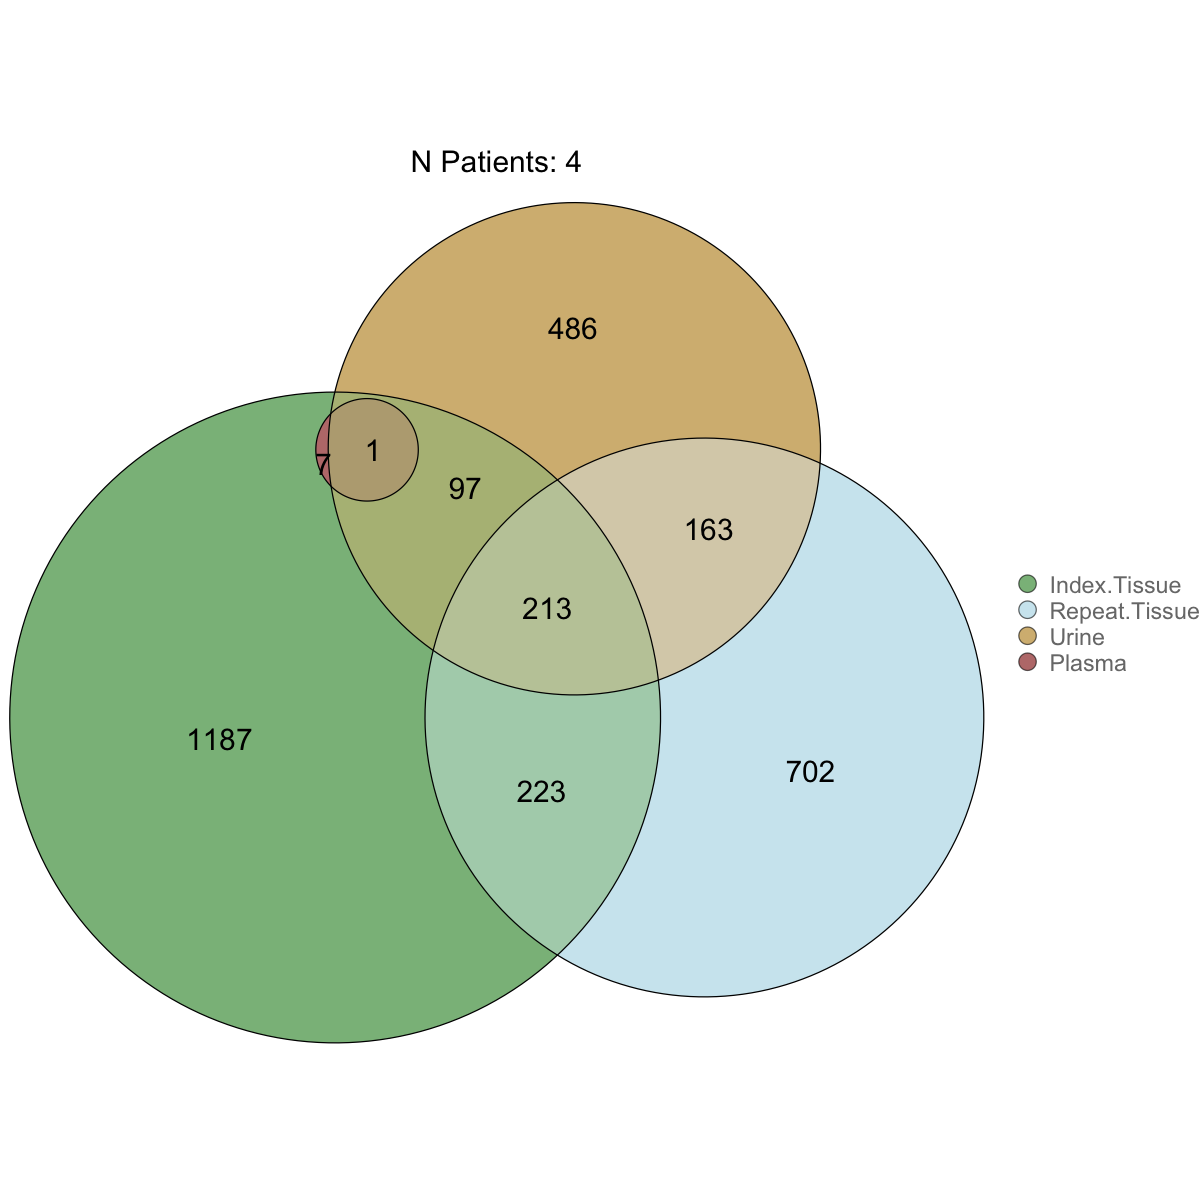

In [297]:
source("~/Desktop/puffin/R/get_concordance_stats.R")

methyl.regions = read.csv("./Methylation_data/Nov_6_2023/test_sample_abnormal_regions_11062023.csv")
head(methyl.regions)
table(methyl.regions$annotation_type)


methyl.promoters = methyl.regions %>% filter(requisition_ID %in% methyl.data$SampleID,
                                             annotation_type == "hg19_genes_promoters",
                                            !is.na(gene_symbol)) %>%
                        mutate(label=paste(subject_id, gene_symbol, sep=":"),
                               SampleID.short = make_SIDshort(requisition_ID, "remove.suffix")) %>% 
                        left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short") %>%
                        filter(study_visit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                              SampleType %!in% c(#"Plasma", 
                                                  "Buffycoat", "Urine Cell Pellet"
                                                )) %>%
                        mutate(SampleType=ifelse(study_visit=="IndexTURBT", "Index.Tissue",
                                        ifelse(study_visit=="RepeatTURBT", "Repeat.Tissue", SampleType)))
samples = methyl.promoters %>% group_by(subject_id) %>% mutate(n_samples=length(unique(SampleType))) %>%
            filter(n_samples >= 4)
methyl.promoters = methyl.promoters %>% filter(subject_id %in% samples$subject_id)

warn_na(methyl.promoters$SampleType)
warn_na(methyl.promoters$study_visit)
n.patients = length(unique(samples$subject_id))
n.patients

plot_list = list()
for (st in unique(methyl.promoters$SampleType)){
    plot_list[[st]] = unique(methyl.promoters %>% filter(SampleType==st) %>% pull(label))
}
names(plot_list)
v <- euler(plot_list) # function converts list to alphabetical order by label
  eulerr_options(padding = unit(5, "mm"))
  plot(v, quantities = list(type = "counts", cex=1.5),
          fills = list(fill = c("forestgreen","lightblue","darkgoldenrod","darkred"), alpha=0.6),
          legend = list(plot=TRUE, fontsize = 14),
          main=glue("N Patients: {n.patients}"))

In [321]:
genes = plot_list[["Urine"]][plot_list[["Urine"]] %in% plot_list[["Repeat.Tissue"]][plot_list[["Repeat.Tissue"]] %in% plot_list[["Index.Tissue"]]]]
length(genes)
#sort(genes)
table(methyl.promoters$subject_id)

genes = unlist(lapply(genes, function(x) str_split(x,":")))
genes = sort(genes[genes %!in% unique(methyl.promoters$subject_id)])
matrix(c(unique(genes), rep("",6)), ncol=10)
                      
table(methyl.)

[1] 215


171769 172229 173334 173509   <NA> 
  1662   1732   1190    971      0 

AARD,BCL2L11,CRISPLD1,GOLPH3L,IFT80,MEGF11,OTX1,PROCA1,SMTN,VOPP1
ACAT2,BCL6,CRYBG1,GPR78,IQUB,MERTK,OXCT2,PROSER3,SNX32,WDR87BP
ACIN1,BDNF,DBNDD2,GPX3,KAT7,MGA,PABPC1L,PUM2,SOX2,WNT3
ACTRT3,BOLL,DGKI,GSK3A,KCNIP2,MIR196A2,PAX6,RAB12,SP9,ZNF135
ADAMTSL1,C17orf107,DLX6-AS1,H2BC9,KLF11,MKNK2,PCDHGB5,RAB31,SPACA6,ZNF154
ADGRD2,CA3,DMRTA2,H3C12,KLF4,MLH1,PCDHGB6,RASSF1,SPAG6,ZNF418
ADHFE1,CALB1,DYNLT2B,H4C6,KLHDC9,MLX,PCDHGC4,RBP1,SPATA20,ZNF667-AS1
AFAP1L2,CCDC106,EHBP1-AS1,HLF,LAMB1,MSC,PENK,REC8,TBX15,ZNF701
AKR1E2,CCDC13,EPHB4,HOXA11,LBX2,MSC-AS1,PER1,RGS22,TBX4,ZNF709
ALX1,CD93,EPHX3,HOXB-AS1,LEPR,MT1A,PFKFB4,RHBDL1,TCF7,ZNF813
AMIGO3,CDKN2A-DT,EPS8L1,HOXB5,LINC00526,MTMR7,PHF11,RSPH6A,TJP2,ZNF814


In [6]:
## sumarize urine beacon # rerun
## number of baseline probes, # number of probes conf. detected 
    # mrd score # number new mutations detected #urine tumorFraction without new muts ## tumroFrac with new muts.
#select("PatientID","SampleID","SampleType","StudyVisit","has.IndexTURBT","has.repeatTURBT",
#                                "IndexPTStage","Repeat.Stage","disease.positive","utDNA.positive","tumorFraction_0")
mrd.table = df_mrd_pre %>% rename("N.baseline.muts.detected.mrdInfo"=mutationCount,
                                  "N.personal.probes.detected.mrdInfo"=mutationCount.mrd,
                                  "N.probes.detected.dynamic.mrdInfo"=mutationCount.mrd.f,
                                  "MRD.score"=mrd.score,
                                  "MRD.call"=mrd.status,
                                  "TF.all.muts.mrdInfo"=tumorfraction.baseline,
                                  "TF.dynamic.muts.mrdInfo"=tumorfraction.baseline.adj,
                                  "TF.dynamic.highqual.muts.mrdInfo"=tumorFraction) %>% 
               select(SampleID.short, PatientID, SampleType, StudyVisit, 
                      #"N.baseline.muts", #extract this one
                      N.baseline.muts.detected.mrdInfo, 
                      #"N.personal.probes", #extract this one
                      N.personal.probes.detected.mrdInfo, 
                      MRD.score, MRD.call,
                      TF.dynamic.muts.mrdInfo, 
                      TF.dynamic.highqual.muts.mrdInfo)
mrd.table

SampleID.short,PatientID,SampleType,StudyVisit,N.baseline.muts.detected.mrdInfo,N.personal.probes.detected.mrdInfo,MRD.score,MRD.call,TF.dynamic.muts.mrdInfo,TF.dynamic.highqual.muts.mrdInfo
<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<lgl>,<dbl>,<dbl>
P219768,173362,Urine,Pre-Repeat TURBT,2,2,1.00,FALSE,0.281,0.0000000000
P219770,172229,Urine,Pre-Repeat TURBT,72,64,8.75,TRUE,0.643,0.6641799480
P219771,173334,Urine,Pre-Repeat TURBT,72,70,68.50,TRUE,0.676,0.0039131614
P219774,171769,Urine,Pre-Repeat TURBT,42,35,2.50,TRUE,0.685,0.2373843811
P217590,172851,Urine,Pre-Repeat TURBT,39,36,9.25,TRUE,0.677,0.1625357483
P217591,172586,Urine,Pre-Repeat TURBT,27,29,2.50,TRUE,0.705,0.3306003890
P217592,173983,Urine,Pre-Repeat TURBT,40,36,36.00,TRUE,0.683,0.0579642593
P217594,169558,Urine,Pre-Repeat TURBT,33,30,31.50,TRUE,0.380,0.0072417228
P217595,161922,Urine,Pre-Repeat TURBT,38,36,29.00,TRUE,0.702,0.0005027954


## power calculations

In [83]:
# power calc for validation cohort - # rerun
# to detect significant difference in median tumor fraction between disease.positive/disease.negative at reTUR
# power curve: Significance vs. sample size given obsv. effect size
# https://cinnipatel.medium.com/power-curve-in-r-8a1e67fb2600

library(WMWssp)
# how many samples required to have 80% power to detect given effect size with confidence alpha=0.01 (p val, FPR)
plot_MWU <- function(case_vals, control_vals, power, metric=""){
    x = case_vals[!is.na(case_vals)]
    y = control_vals[!is.na(control_vals)]
    #effect_size = round(((mean(x) - mean(y))/mean(y)) * 100, 1)  #pct avg decrease from disease.positive to disease.nge
    effect_size = round((median(x) - median(y)), 3)
    print(effect_size)
    sig.level.list <- seq(.01,0.10,.01)  #Vector of sig..level 
    samp.out <- NULL
    for(a in sig.level.list){
      ssp <- WMWssp(x , 
                  y,
                  alpha = a, 
                  power = power, 
                  t = 7/10, 
                  simulation=T, nsim=100)
      res = summary(ssp)
      n.xxx  <-  res$Results[[9]]
      print(n.xxx)
      n.xxx <- data.frame(sig.level=a, sample.size=n.xxx)
      samp.out <- rbind(samp.out,n.xxx)
    }
    gg <- ggplot(samp.out, aes(sample.size,sig.level))+
      geom_line() + theme(text=element_text(size=15)) +
      #theme_minimal() +
      geom_hline(yintercept = .05,lty=2, color='blue') +
      geom_point() +
      labs(title=sprintf("Wilcoxon test, power=0.80\n%s = %s", metric, effect_size),
           y="Significance Level (p-value)",
           x="Sample size")
    show(gg)
    return(samp.out)
    }

[1] 0.019
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9800000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


[1] 0.162
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9700000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9400000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

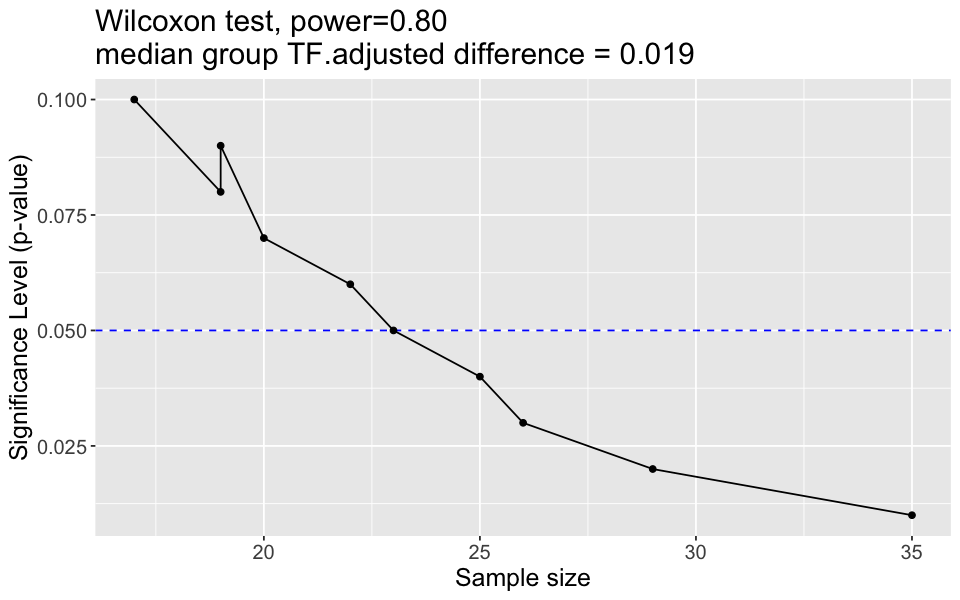

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


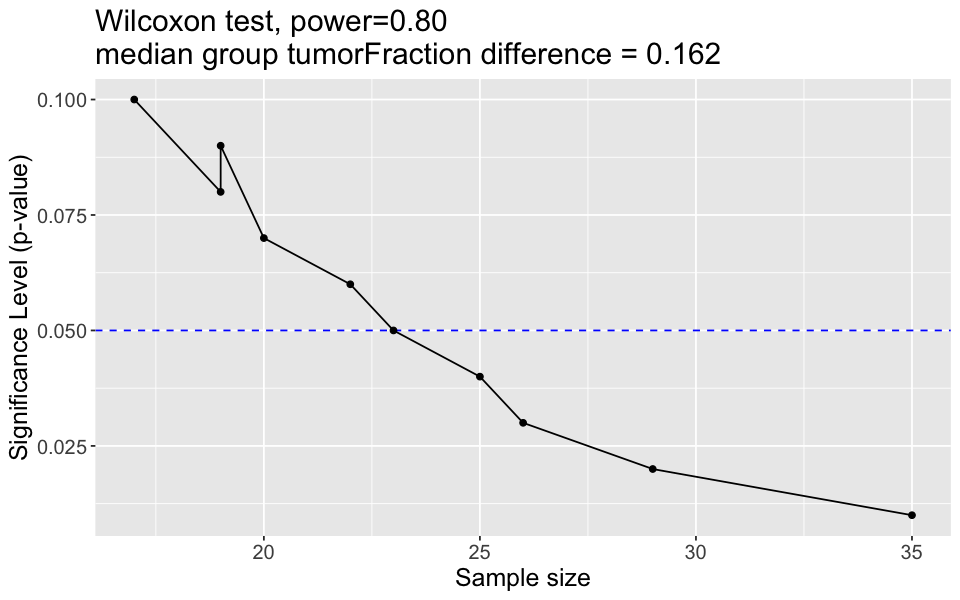

In [88]:
## BEACON tumorFraction measures
plot_MWU(df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group TF.adjusted difference")

plot_MWU(df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group tumorFraction difference")

[1] 0.055
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.1428571
N (total sample size needed) 27.1327432
t=n1/N                        0.7000000
n1 in Group 1                18.9929202
n2 in Group 2                 8.1398229
N rounded                    28.0000000
n1 rounded                   19.0000000
n2 rounded                    9.0000000
[1] 28
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9200000
Estimated relative effect p   0.1428571
N (total sample size needed) 22.8659188
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,28
0.02,24
0.03,22
0.04,20
0.05,19
0.06,17
0.07,16
0.08,16
0.09,15


[1] 0.109
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                               Results
alpha (2-sided)               0.010000
Power                         0.800000
Simulated Power               0.970000
Estimated relative effect p   0.177381
N (total sample size needed) 31.113570
t=n1/N                        0.700000
n1 in Group 1                21.779499
n2 in Group 2                 9.334071
N rounded                    32.000000
n1 rounded                   22.000000
n2 rounded                   10.000000
[1] 32
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                               Results
alpha (2-sided)               0.020000
Power                         0.800000
Simulated Power               0.950000
Estimated relative effect p   0.177381
N (total sample size needed) 26.238465
t=n1/N                     

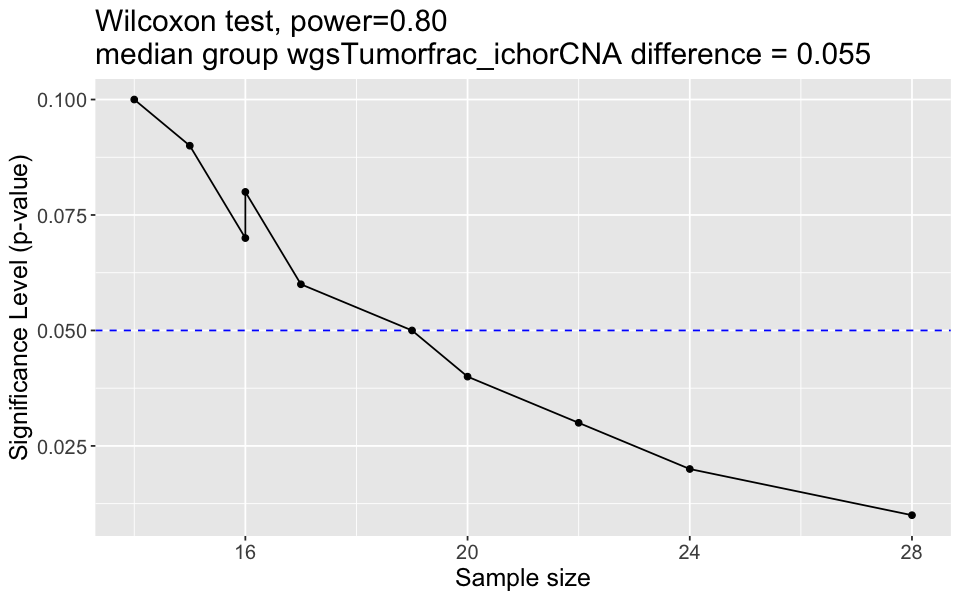

sig.level,sample.size
<dbl>,<dbl>
0.01,32
0.02,27
0.03,25
0.04,22
0.05,20
0.06,19
0.07,19
0.08,17
0.09,17


[1] 4.065
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                              Results
alpha (2-sided)               0.01000
Power                         0.80000
Simulated Power               0.99000
Estimated relative effect p   0.10000
N (total sample size needed) 21.87137
t=n1/N                        0.70000
n1 in Group 1                15.30996
n2 in Group 2                 6.56141
N rounded                    23.00000
n1 rounded                   16.00000
n2 rounded                    7.00000
[1] 23
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                              Results
alpha (2-sided)               0.02000
Power                         0.80000
Simulated Power               0.94000
Estimated relative effect p   0.10000
N (total sample size needed) 18.35170
t=n1/N                        0.70000
n1 in G

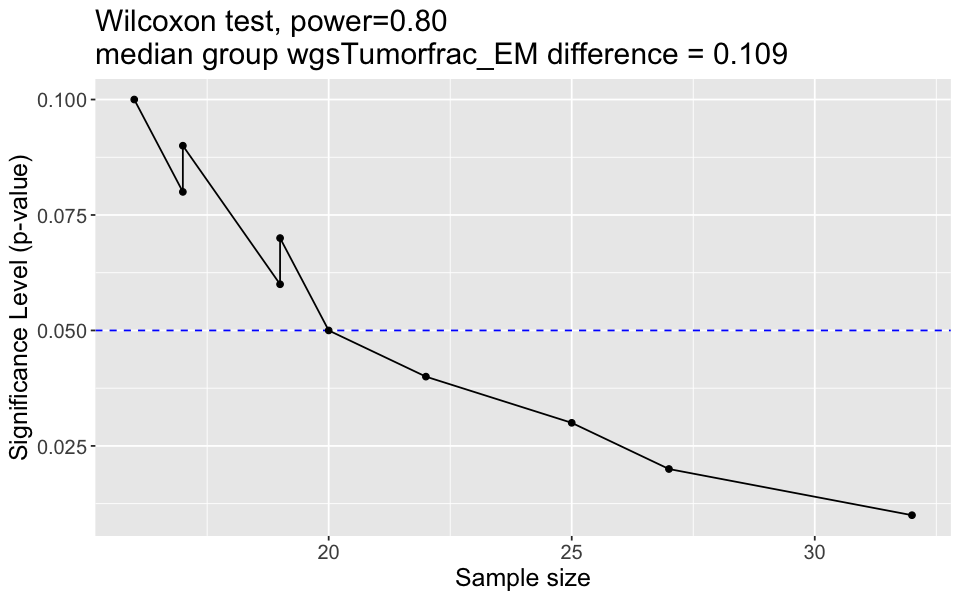

sig.level,sample.size
<dbl>,<dbl>
0.01,23
0.02,19
0.03,17
0.04,16
0.05,15
0.06,13
0.07,13
0.08,12
0.09,12


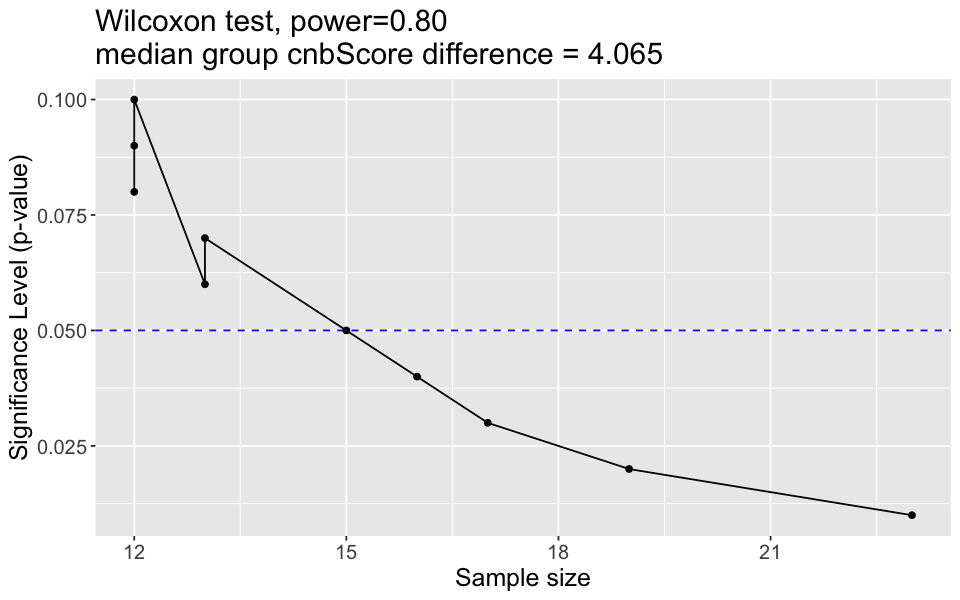

In [89]:
# LPWGS power
plot_MWU(df_urine_lpwgs_pre$wgsTumorfrac_ichorCNA[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$wgsTumorfrac_ichorCNA[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_ichorCNA difference")

plot_MWU(df_urine_lpwgs_pre$wgsTumorfrac_EM[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$wgsTumorfrac_EM[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_EM difference")

plot_MWU(df_urine_lpwgs_pre$cnbScore[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$cnbScore[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group cnbScore difference")

## LPWGS pre-repeat urine analysis

In [131]:
df_urine_lpwgs_pre = df_lpwgs_all %>% filter(StudyVisit=="Pre-RepeatTURBT", SampleType=="Urine") # rerun
nrow(df_urine_lpwgs_pre) # 44
# df = df_urine_pre %>% 
#     select(PatientID, StudyVisit, disease.positive, wgsTumorfrac_ichorCNA) %>% arrange(PatientID)
# write.csv(df, "./pre_repeat_urine_WGS_TF_list.csv", row.names=F)
source("~/Desktop/puffin/R/helper_functions.R")

[1] 44

Complete cases wgsTumorfrac_ichorCNA by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 0
TRUE median: 0.07135

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 30, p-value = 3.589e-05
alternative hypothesis: true location shift is not equal to 0

  disease.positive wgsTumorfrac_ichorCNA    label
1            FALSE                0.4651 p=<0.001
2             TRUE                    NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



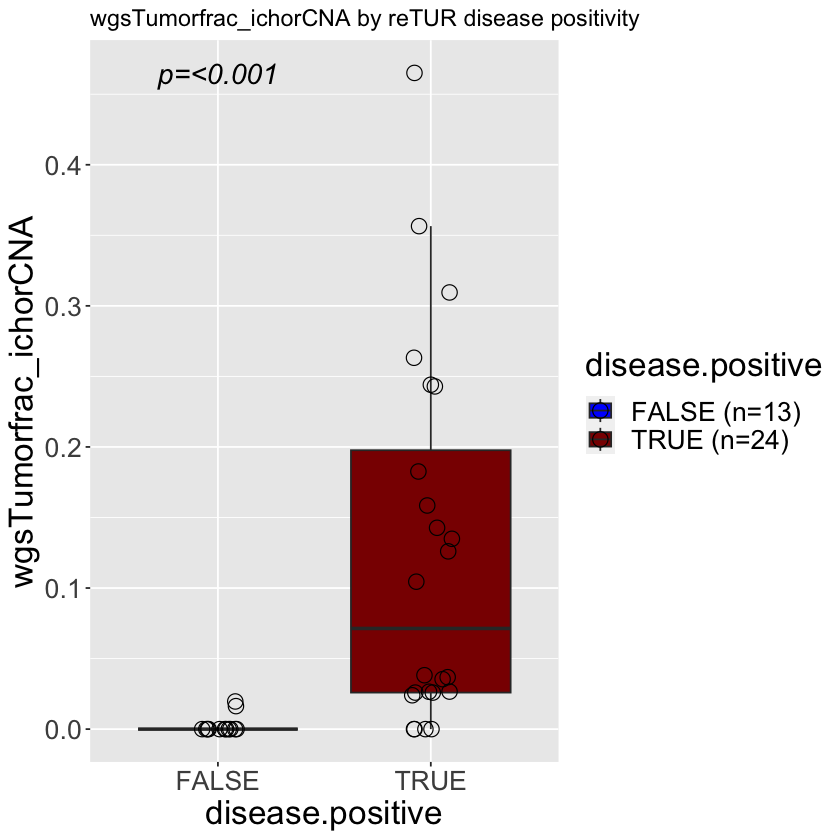

  threshold specificity sensitivity
1    0.0218           1   0.8333333
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.903846153846154"
Complete cases cnbScore by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 3.88570603348226
TRUE median: 8.1595036851768

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 23, p-value = 2.494e-05
alternative hypothesis: true location shift is not equal to 0

  disease.positive cnbScore    label
1            FALSE 10.80927 p=<0.001
2             TRUE       NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



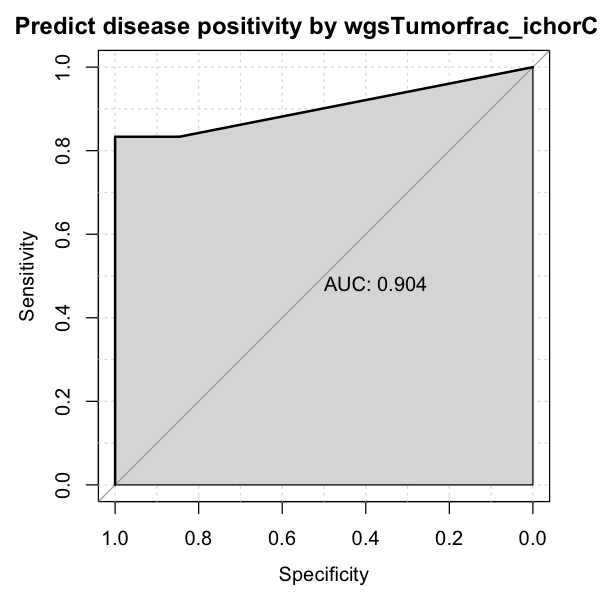

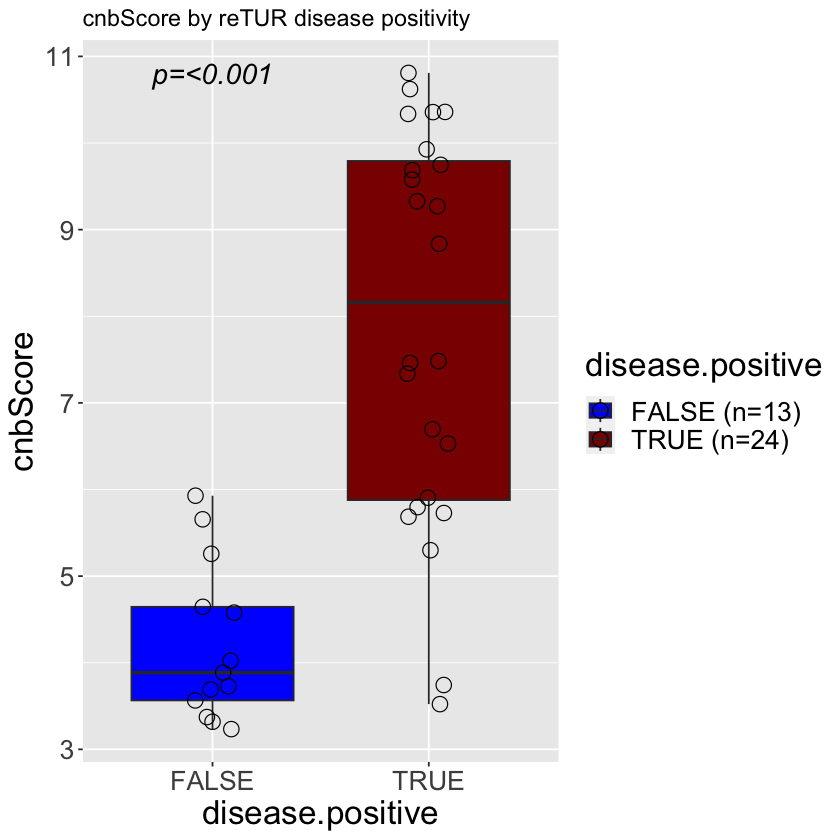

  threshold specificity sensitivity
1  5.670669   0.9230769       0.875
[1] "target sens 1"
  threshold specificity sensitivity
1  3.447388   0.2307692           1
[1] "AUC: 0.926282051282051"
Complete cases wgsTumorfrac_EM by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 0
TRUE median: 0.10874038682539

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 45.5, p-value = 0.0001373
alternative hypothesis: true location shift is not equal to 0

  disease.positive wgsTumorfrac_EM    label
1            FALSE       0.7317695 p=<0.001
2             TRUE              NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



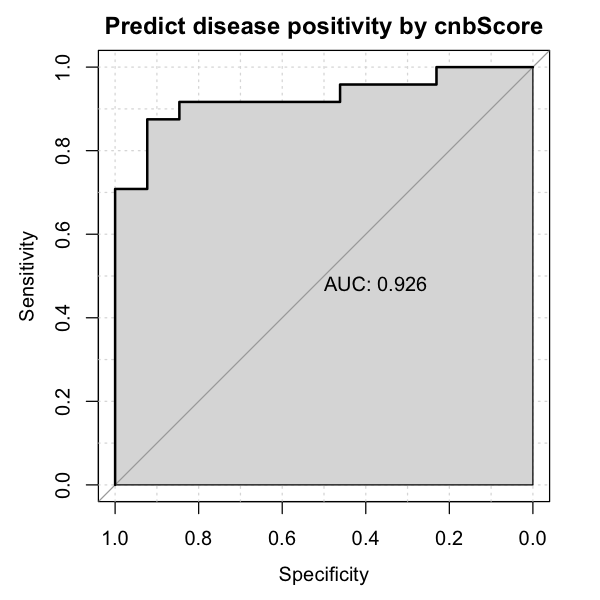

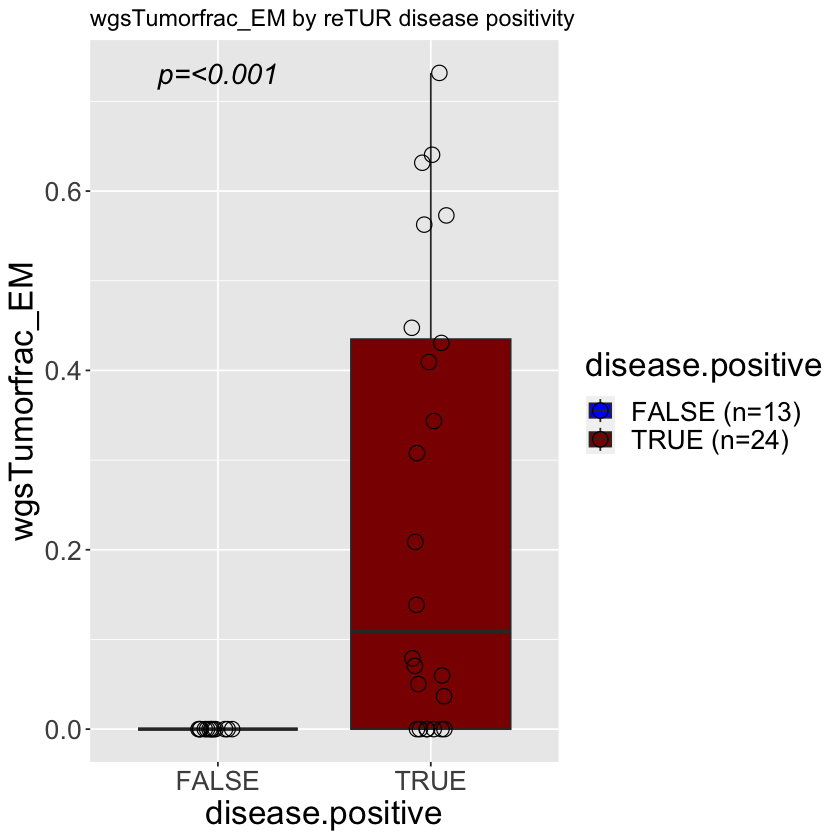

   threshold specificity sensitivity
1 0.01830617           1   0.7083333
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.854166666666667"


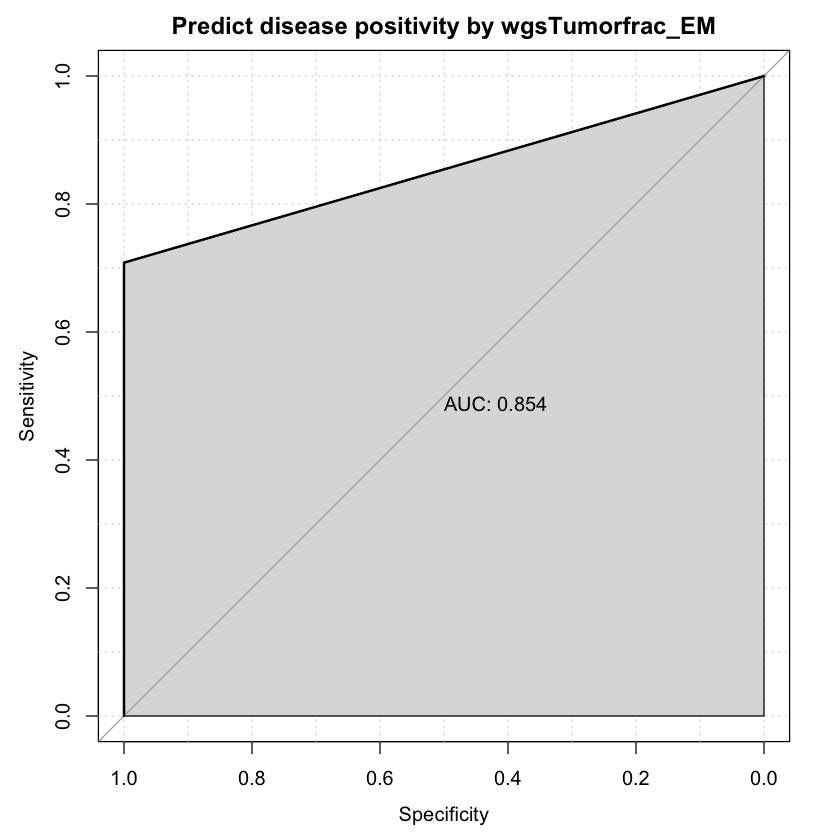

In [132]:
# correlation of LPWGS with disease positivity and prediction AUCs # rerun
for (stat in c('wgsTumorfrac_ichorCNA', 'cnbScore', 'wgsTumorfrac_EM')){
    options(repr.plot.width=5, repr.plot.height=5)
    g <- quick_boxplot(df_ngsqc.urine.mrd, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = FALSE, plot.title = glue("{stat} by reTUR disease positivity"))
    show(g)
    options(repr.plot.width=7, repr.plot.height=7)
    get_sens_spec(df_ngsqc.urine.mrd, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
}

## BEACON

In [25]:
# probe library accounting

df_samples_all = make_names(df_samples_all) %>% mutate(SampleID.short=make_SIDshort(SampleID,"strict"))

pipeline.probes = read_excel("hybrid_probe_mrd/probe_sets_02072024.xlsx", sheet="probe_sets_02072024") %>%
                    mutate(SampleID.short=make_SIDshort(file.sampleid,"strict"))

probes = df_samples_all %>% select(PatientID, SampleID.short, EX...QC, EPIC, MRD, WES., MRDprobe) %>%
                left_join(pipeline.probes, by="SampleID.short") %>% filter(!is.na(person))
head(probes)

write.csv(probe.summary %>% mutate(across(everything(), as.character)), "Probe_summary_02082024.csv", row.names=FALSE)

SampleID.short format: strict
SampleID.short format: strict


PatientID,SampleID.short,EX...QC,EPIC,MRD,WES.,MRDprobe,person,size,month,day,year,date,file,file.sampleid,suffix
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
116381,P228837,NA,WOP00631,NA,WOP00631,MRD2,pdu,7629,Nov,12,2024,Nov.12.2024,P228837_U_targets.rds,P228837,NA
116381,P228837,NA,WOP00631,NA,WOP00631,MRD2,pdu,5395,Sep,14,2024,Sep.14.2024,P228837_1_targets.rds,P228837,NA
116381,P228837,NA,WOP00631,NA,WOP00631,MRD2,pdu,5545,Aug,15,2024,Aug.15.2024,P228837_targets.rds,P228837,NA
152237,P228839,NA,WOP00631,NA,WOP00631,MRD2,pdu,10039,Nov,12,2024,Nov.12.2024,P228839_U_targets.rds,P228839,NA
152237,P228839,NA,WOP00631,NA,WOP00631,MRD2,pdu,7767,Sep,14,2024,Sep.14.2024,P228839_1_targets.rds,P228839,NA
152237,P228839,NA,WOP00631,NA,WOP00631,MRD2,pdu,7655,Aug,15,2024,Aug.15.2024,P228839_targets.rds,P228839,NA


In [27]:
probe.summary = probes %>% group_by(PatientID) %>% distinct(file, .keep_all=TRUE) %>% ungroup() %>%
                    pivot_wider(names_from = "date", values_from = "file",id_cols = "PatientID")
probe.summary

Warning message:
“Values from `file` are not uniquely identified; output will contain list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} %>%
  dplyr::group_by(PatientID, date) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)”


PatientID,Nov.12.2024,Sep.14.2024,Aug.15.2024,Dec.3.2024,Oct.22.2022,Dec.3.2022,Jul.23.2023,Jul.26.2023,Aug.17.2024,Nov.4.2024,Jul.20.2023,Nov.5.2024,Jul.5.2023
<chr>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
116381,P228837_....,P228837_....,P228837_....,,,,,,,,,,
152237,P228839_....,P228839_....,P228839_....,,,,,,,,,,
161922,,,,P220081_....,P220081_....,,,,,,,,
165028,P228840_....,P228840_....,P228840_....,,,,,,,,,,
167162,P228841_....,P228842_....,P228842_....,,,,,,,,,,
169558,,,,P220073_....,P220073_....,,,,,,,,
171374,,,,,,P219772_....,,,,,,,
171769,,,,P220077_....,,,P219774_....,P219774p....,P220077_....,P220077_....,,,
171821,P228843_....,P228843_....,,,,,,P228675p....,P228843_....,,P228675_....,,


In [32]:
write.csv(probe.summary %>% mutate(across(everything(), as.character)), "Probe_summary_02082024.csv", row.names=FALSE)

In [35]:
samples = read_excel("./NMIBC_STUDY_PLAN_and_avail_data_BG_02052024.xlsx", sheet="SeqQC")
head(samples)

table(samples$SampleType, samples$Assay)


Assay,Shipping_Batch,SampleID,PatientID,SampleID.short,externalSampleID,StudyVisit,SampleType,Total.reads..M.,Mapped.reads..M.,Target unique fragment coverage,Consensus reads (M),Duplication.rate....,Target.unique.fragment.coverage,Target.read.coverage,Mean target read coverage,Percentage of target > 20% Mean coverage,Within 2-fold (%) after dedup,Within 2-fold (%) before dedup,onTarget rate (%),onTarget rate ext200 (%),gcRatio.low,gcRatio.high,Mean error rate (%) after dedup,background.50% after dedup,background.99% after dedup,Fragment_Size_Mode,Fragment_Size_Bandwidth,Softclip ratio,Double strand ratio,BC_totalCount,SNP_BC,Panel,Workorder
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
WES+,Batch 1,P217589,172602,P217589,NA,Pre-Repeat TURBT,Supernatant,1170,1160,99.7,527.0,54.7,5150,14400,15524,99.7,69.4,57.5,71.099999999999994,89.6,0.65800000000000003,1.46,0.00138,0.1300,0.605,136.1,118.3918,2.250,3.51,NA,12011010100110001011210000001110010',NA,NA
WES+,Batch 1,P217590,172851,P217590,NA,Pre-Repeat TURBT,Supernatant,1050,1050,99.8,480.0,54.1,5259,12400,15700,99.2,60.8,54.2,67.5,89.5,0.627,1.4,0.02530,0.1390,0.657,112.0,217.1263,0.643,100.00,25074931,20002001201102112000011110100001121',NA,NA
BEACON.index.baseline.only,Batch 1,P217590,172851,P217590,06S22022824,Pre-Repeat TURBT,Supernatant,NA,NA,8305.0,13.5,NA,NA,NA,NA,NA,83.0,NA,NA,NA,NA,NA,0.05480,0.0935,0.447,109.5,164.9924,2.610,3.51,5054107,20002001101102112000021110100001121',NA,NA
WES+,Batch 1,P217591,172586,P217591,NA,Pre-Repeat TURBT,Supernatant,1130,1130,99.8,475.0,57.8,5298,14600,15947,99.5,59.9,54.1,71.099999999999994,90.2,0.64300000000000002,1.41,0.02240,0.1290,0.587,109.5,116.1083,0.762,100.00,24124680,11102001100000001010210010000112021',NA,NA
BEACON.index.baseline.only,Batch 1,P217591,172586,P217591,06S22017463,Pre-Repeat TURBT,Supernatant,NA,NA,7315.0,12.1,NA,NA,NA,NA,NA,74.6,NA,NA,NA,NA,NA,0.04130,0.0837,0.432,91.4,103.7000,2.340,3.33,4361695,11102001100000001010210010000112021',NA,NA
BEACON.index.baseline.only,Batch 1,P217592,173983,P217592,06S22034638,Pre-Repeat TURBT,Supernatant,NA,NA,26655.0,36.0,NA,NA,NA,NA,NA,94.8,NA,NA,NA,NA,NA,0.06190,0.0583,0.428,156.1,185.3290,1.440,7.28,6315783,00011101101220010020101110102022021',NA,NA


             
              BEACON.hybrid.tissues BEACON.hybrid.urine.tissue
  FFPE                            0                          0
  Supernatant                    30                         23
  Tissue                          0                          0
  <NA>                            0                          0
             
              BEACON.index.baseline.only WES+ <NA>
  FFPE                                 0  134    0
  Supernatant                         19   40    0
  Tissue                               0   18    0
  <NA>                                 0    0    0

In [14]:
# prelim batch 4 mrd plots

## combine
mrd.info.4 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/batch_4_mrd_data/WOP01633_PRDC-MOFFITT-NMIBC-22001_Other_all_2024-03-14.csv")
head(mrd.info.4)

# mrd.info.5 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/batch_5_mrd_data/PD_mrd_analysis_batch5/WOP01651_WOP01646_WOP01656_PRDC-MOFFITT-NMIBC-22001_Other_all_2024-03-13.csv")
# head(mrd.info.5)

df_ngsqc.preur <- mrd.info.4 #rbind.common(mrd.info.5, mrd.info.4)
df_ngsqc.preur = df_ngsqc.preur %>% filter(!grepl("specific|pool", Baseline, ignore.case = T))

df_ngsqc.preur = df_ngsqc.preur %>%
        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict")) %>% 
        select(-PatientID) %>% distinct()
nrow(df_ngsqc.preur)

#df_ngsqc.urine.mrd %>% filter(grepl("fail", QC_Status, ignore.case=TRUE)) # none

#### add sample studyvisit and PID
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
                        rename("StudyVisit.sample"="StudyVisit", "PatientID.sample"="PatientID", 
                               "SampleID.short.sample"="SampleID.short", "SampleID.sample"="SampleID") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
                               StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
                               PatientID.old.sample = PatientID.sample,
                               PatientID.sample = as.character(fix_PIDs(PatientID.old.sample)),
                               Baseline.short = make_SIDshort(Baseline, "strict"))
nrow(df_ngsqc.preur)
### add baseline study visit
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by=c("Baseline.short"="SampleID.short")) %>%
                        rename("StudyVisit.baseline"="StudyVisit", "PatientID.baseline"="PatientID",
                               "SampleID.baseline"="Baseline") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.baseline),
                               StudyVisit.baseline = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.baseline, StudyVisit2))),
                               PatientID.old.baseline = PatientID.baseline,
                               PatientID.baseline = as.character(fix_PIDs(PatientID.old.baseline)))
nrow(df_ngsqc.preur)
head(df_ngsqc.preur)
#df_ngsqc.preur = df_ngsqc.preur %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()
df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")

# interesting to check TF of urine sampleID vs. basline=sampleID. Do we get TF.WES==TF.BEACON?
table(df_ngsqc.preur$SampleID.sample, df_ngsqc.preur$StudyVisit.baseline)

stopifnot(all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline))

table(df_ngsqc.preur$StudyVisit.sample) 




,SampleID,PatientID,Baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P219772,171374,P237609A01,16,16,0,17,17,16,13.75,12.500,13.75,TRUE,TRUE,1,0.007053956,0.006138926,0.006138926,1.800357,0.34851556,87.412,0.93283,0.93283,0.0176145,0.02024000,0.01761450,0.01643133,0.03537,0.03537034,PREDICINEMRD_V1B__P237609A01,P219772_20240304,06S21164690,Not_available,Pre-Repeat TURBT,Urine_Supernatant
2,P233058A01,182910,P233058A01,60,60,9,55,55,55,56.50,55.625,56.50,TRUE,FALSE,1,0.221126326,0.212642552,0.102967791,66.358758,0.06325032,62.809,0.77156,0.77156,3.3619206,3.49605078,1.62794105,1.25605420,0.78885,0.78885170,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant
3,P233058A01,182910,P234621A01,50,50,35,45,41,41,42.75,35.875,42.75,TRUE,TRUE,5,0.017122260,0.015808092,0.013901435,65.128786,0.17468276,41.940,0.63566,0.50059,0.0904960,0.09801917,0.07958103,0.03983747,0.78882,0.16123759,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant
4,P233058A01,182910,P234621A01_Specific,2,8,76,10,10,8,8.50,9.875,10.75,TRUE,TRUE,1,0.248158563,0.278794181,0.278794181,65.128786,NA,38.909,0.63566,0.63566,NA,NA,NA,NA,0.78882,0.78882413,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant
5,P233058A01,182910,Pool,NA,NA,19,56,56,56,59.50,58.625,59.50,TRUE,FALSE,1,0.231783539,0.231542033,0.109258557,66.358758,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant
6,P233062A01,179692,P233062A01,26,26,34,10,9,9,9.00,8.250,9.00,TRUE,FALSE,1,0.088726697,0.088616778,0.088616778,18.524154,0.05225559,24.684,0.68012,0.39594,1.6958335,1.69793697,1.69583348,0.67144831,0.18027,0.18026615,PREDICINEMRD_V1B__P233062A01,P233062A01_20240304,06S22121171,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant


SampleID.short format: strict


[1] 52

 [1] "171374" "182910" "179692" "181439" "181568" "184485" "175831" "184615"
 [9] "184289" "184957" "186652" "185581" "185382" "185212" "182435" "187807"
[17] "188867" "187204" "189342" "189083" "190233" "186478" "191632" "192682"
[25] "193186"
SampleID.short format: strict


[1] 52

 [1] "171374" "182910" "179692" "181439" "181568" "184485" "175831" "184615"
 [9] "184289" "184957" "186652" "185581" "185382" "185212" "182435" "187807"
[17] "188867" "187204" "189342" "189083" "190233" "186478" "191632" "192682"
[25] "193186"


[1] 52

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType,SampleID.short.sample,StudyVisit.sample,PatientID.sample,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P219772,P237609A01,16,16,0,17,17,16,13.750,12.500,13.750,TRUE,TRUE,1,0.007053956,0.006138926,0.006138926,1.800357,0.34851556,87.4120,0.93283,0.93283,0.01761450,0.02024000,0.01761450,0.016431330,0.035370,0.035370338,PREDICINEMRD_V1B__P237609A01,P219772_20240304,06S21164690,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P219772,Pre-RepeatTURBT,171374,NA,171374,P237609,IndexTURBT,171374,171374
2,P233058A01,P233058A01,60,60,9,55,55,55,56.500,55.625,56.500,TRUE,FALSE,1,0.221126326,0.212642552,0.102967791,66.358758,0.06325032,62.8090,0.77156,0.77156,3.36192064,3.49605078,1.62794105,1.256054199,0.788850,0.788851705,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233058,Pre-RepeatTURBT,182910,NA,182910,P233058,Pre-RepeatTURBT,182910,182910
3,P233058A01,P234621A01,50,50,35,45,41,41,42.750,35.875,42.750,TRUE,TRUE,5,0.017122260,0.015808092,0.013901435,65.128786,0.17468276,41.9400,0.63566,0.50059,0.09049600,0.09801917,0.07958103,0.039837470,0.788820,0.161237590,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233058,Pre-RepeatTURBT,182910,NA,182910,P234621,IndexTURBT,182910,182910
4,P233062A01,P233062A01,26,26,34,10,9,9,9.000,8.250,9.000,TRUE,FALSE,1,0.088726697,0.088616778,0.088616778,18.524154,0.05225559,24.6840,0.68012,0.39594,1.69583348,1.69793697,1.69583348,0.671448309,0.180270,0.180266152,PREDICINEMRD_V1B__P233062A01,P233062A01_20240304,06S22121171,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233062,Pre-RepeatTURBT,179692,NA,179692,P233062,Pre-RepeatTURBT,179692,179692
5,P233062A01,P234593A01,27,27,114,7,3,3,2.125,1.375,2.125,TRUE,TRUE,1,0.004221190,0.003582663,0.003582663,1.962923,0.20818115,4.8941,0.74783,0.13300,0.01720936,0.02027652,0.01720936,0.002288844,0.038503,0.002288844,PREDICINEMRD_V1B__P233062A01,P233062A01_20240304,06S22121171,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233062,Pre-RepeatTURBT,179692,NA,179692,P234593,IndexTURBT,179692,179692
6,P233062A01,P237635A01,26,26,113,5,4,4,3.125,2.375,3.125,TRUE,TRUE,1,0.015007899,0.037589767,0.037589767,4.013066,0.35984848,7.5758,0.72811,0.14085,0.10445998,0.04170616,0.10445998,0.014713189,0.077165,0.077164648,PREDICINEMRD_V1B__P233062A01,P233062A01_20240304,06S22121171,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233062,Pre-RepeatTURBT,179692,NA,179692,P237635,RepeatTURBT,179692,179692


            
             IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  P219772             1               0           0    0
  P233058A01          1               1           0    0
  P233062A01          1               1           1    0
  P233068A01          1               1           0    0
  P233070A01          1               1           0    0
  P233077A01          1               1           0    0
  P233080A01          1               1           0    0
  P233086A01          1               1           0    0
  P233092A01          1               1           0    0
  P233096A01          1               1           0    0
  P233100A01          1               1           0    0
  P233102A01          1               1           0    0
  P233106A01          1               1           0    0
  P233110A01          1               1           0    0
  P233116A01          1               1           0    0
  P233122A01          1               1           0    0
  P233128A01      


Pre-RepeatTURBT            <NA> 
             52               0 

,SampleID,PatientID,Baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P217589,172602,P237608A01,64,64,110,38,5,4,4.250,4.000,5.250,TRUE,TRUE,1,0.01746929,0.02208572,0.02208572,2.25405,0.46121988,12.658,0.40288,0.25316,0.04788545,0.03787628,0.04788545,0.01212268,0.044087000,0.04408726,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
2,P217589,172602,P220072,20,20,110,18,18,18,21.250,20.000,21.250,TRUE,FALSE,1,0.16020066,0.16036977,0.16036977,28.47358,0.05688338,12.941,0.25551,0.25551,2.81927307,2.81630010,2.81927307,0.72035246,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
3,P217589,172602,P220072_Specific,20,20,110,18,18,18,21.250,20.000,21.250,TRUE,FALSE,1,0.16020066,0.16036977,0.16036977,28.47358,0.05688338,12.941,0.25551,0.25551,2.81927307,2.81630010,2.81927307,0.72035246,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
4,P217589,172602,P217589,61,61,74,59,59,59,51.625,50.375,51.625,TRUE,FALSE,1,0.19801751,0.14718433,0.10198811,28.47358,0.06018306,29.386,0.54871,0.45424,2.44561068,3.29025322,1.69463145,0.76976939,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
5,P217589,172602,P217589_Specific,61,61,74,59,59,59,51.625,50.375,51.625,TRUE,FALSE,1,0.19801751,0.14718433,0.10198811,28.47358,0.06018306,29.386,0.54871,0.45424,2.44561068,3.29025322,1.69463145,0.76976939,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
6,P217589,172602,Pool,NA,NA,229,55,6,4,4.250,4.250,5.500,TRUE,TRUE,1,0.01746929,0.02208572,0.02208572,2.25405,NA,NA,NA,NA,NA,NA,NA,NA,0.009243093,NA,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant


SampleID.short format: strict


[1] 98

 [1] "172602" "196111" "196412" "195312" "195407" "195874" "195778" "195451"
 [9] "194650" "193330" "193187" "193248" "189953" "185159" "182170" "178919"
[17] "173743" "76224"  "194171" "192682"
SampleID.short format: strict


[1] 98

 [1] "172602" "196111" "196412" "195312" "195407" "195874" "195778" "195451"
 [9] "194650" "193330" "193187" "193248" "189953" "185159" "182170" "178919"
[17] "173743" "76224"  "194171" "192682"


[1] 98

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType,SampleID.short.sample,StudyVisit.sample,PatientID.sample,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P217589,P237608A01,64,64,110,38,5,4,4.25000,4.000,5.250,TRUE,TRUE,1,0.017469295,0.02208572,0.02208572,2.254050,0.46121988,12.6580,0.40288,0.253160,0.04788545,0.03787628,0.04788545,0.01212268,0.044087,0.04408726,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P237608,IndexTURBT,172602,172602
2,P217589,P220072,20,20,110,18,18,18,21.25000,20.000,21.250,TRUE,FALSE,1,0.160200655,0.16036977,0.16036977,28.473581,0.05688338,12.9410,0.25551,0.255510,2.81927307,2.81630010,2.81927307,0.72035246,0.436610,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P220072,RepeatTURBT,172602,172602
3,P217589,P217589,61,61,74,59,59,59,51.62500,50.375,51.625,TRUE,FALSE,1,0.198017506,0.14718433,0.10198811,28.473581,0.06018306,29.3860,0.54871,0.454240,2.44561068,3.29025322,1.69463145,0.76976939,0.436610,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P217589,Pre-RepeatTURBT,172602,172602
4,P237535A01,P237645A01,11,11,86,4,4,4,3.62500,1.000,3.625,FALSE,TRUE,3,0.008026283,0.02976484,0.02976484,3.026863,NA,52.8530,0.69155,0.691550,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P237645A01,P237535A01_20240308,06S23105566,Pre-Repeat TURBT,NA,Urine_Supernatant,P237535,Pre-RepeatTURBT,196111,NA,196111,P237645,RepeatTURBT,196111,196111
5,P237535A01,P237535A01,46,46,12,38,38,38,36.00000,33.375,36.000,TRUE,FALSE,3,0.020532884,0.01964849,0.01557436,5.923961,0.01263797,4.7365,0.65446,0.090446,1.55471896,1.62469791,1.23234651,0.11146081,0.076169,0.07616882,PREDICINEMRD_V1B__P237645A01,P237535A01_20240308,06S23105566,Pre-Repeat TURBT,NA,Urine_Supernatant,P237535,Pre-RepeatTURBT,196111,NA,196111,P237535,Pre-RepeatTURBT,196111,196111
6,P237537A01,P237651A01,53,53,18,56,51,49,54.58553,53.211,56.586,TRUE,TRUE,3,0.084720809,0.08377222,0.05913990,18.630296,0.33494474,95.0620,0.97468,0.974680,0.25010759,0.25293966,0.17656614,0.17209549,0.213570,0.21357285,PREDICINEMRD_V1B__P237651A01,P237537A01_20240308,06S23103343,Pre-Repeat TURBT,NA,Urine_Supernatant,P237537,Pre-RepeatTURBT,196412,NA,196412,P237651,IndexTURBT,196412,196412


            
             IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  P217589             1               1           1    0
  P233155A01          1               0           1    0
  P237532A01          0               1           1    0
  P237535A01          0               1           1    0
  P237537A01          1               1           0    0
  P237538A01          1               1           0    0
  P237541A01          1               1           1    0
  P237543A01          1               1           1    0
  P237545A01          1               1           1    0
  P237546A01          1               1           1    0
  P237549A01          1               1           1    0
  P237551A01          1               1           1    0
  P237553A01          1               1           1    0
  P237557A01          1               1           1    0
  P237558A01          1               1           1    0
  P237561A01          1               1           0    0
  P237562A01      


Pre-RepeatTURBT            <NA> 
             98               0 

PatientID,Recurrence.Follow.Up,Repeat.Tumor,disease.positive
<chr>,<dbl>,<dbl>,<lgl>
76224,1,3,TRUE
116381,1,3,TRUE
152237,0,0,FALSE
161922,1,0,FALSE
165028,1,4,TRUE
167162,0,4,TRUE


,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline,Recurrence.Follow.Up,Repeat.Tumor,disease.positive
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,P217589,P237608A01,64,64,110,38,5,4,4.25000,4.000,5.250,TRUE,TRUE,1,0.017469295,0.022085723,0.022085723,2.2540502,0.46121988,12.658,0.40288,0.25316,0.04788545,0.03787628,0.04788545,0.01212268,0.044087,0.04408726,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P237608,IndexTURBT,172602,172602,1,1,TRUE
2,P217589,P220072,20,20,110,18,18,18,21.25000,20.000,21.250,TRUE,FALSE,1,0.160200655,0.160369768,0.160369768,28.4735812,0.05688338,12.941,0.25551,0.25551,2.81927307,2.81630010,2.81927307,0.72035246,0.436610,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P220072,RepeatTURBT,172602,172602,1,1,TRUE
3,P237535A01,P237645A01,11,11,86,4,4,4,3.62500,1.000,3.625,FALSE,TRUE,3,0.008026283,0.029764841,0.029764841,3.0268634,NA,52.853,0.69155,0.69155,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P237645A01,P237535A01_20240308,06S23105566,Pre-Repeat TURBT,NA,Urine_Supernatant,P237535,Pre-RepeatTURBT,196111,NA,196111,P237645,RepeatTURBT,196111,196111,0,1,TRUE
4,P237537A01,P237651A01,53,53,18,56,51,49,54.58553,53.211,56.586,TRUE,TRUE,3,0.084720809,0.083772220,0.059139901,18.6302960,0.33494474,95.062,0.97468,0.97468,0.25010759,0.25293966,0.17656614,0.17209549,0.213570,0.21357285,PREDICINEMRD_V1B__P237651A01,P237537A01_20240308,06S23103343,Pre-Repeat TURBT,NA,Urine_Supernatant,P237537,Pre-RepeatTURBT,196412,NA,196412,P237651,IndexTURBT,196412,196412,0,3,TRUE
5,P237543A01,P237650A01,56,56,24,51,51,51,53.50000,53.500,53.500,TRUE,TRUE,0,0.005134004,0.004263219,0.003088336,0.8993872,0.05865776,18.681,0.39063,0.31481,0.07267954,0.08752472,0.05265008,0.01657477,0.016406,0.01640567,PREDICINEMRD_V1B__P237650A01,P237543A01_20240308,06S23092073,Pre-Repeat TURBT,NA,Urine_Supernatant,P237543,Pre-RepeatTURBT,195312,NA,195312,P237650,IndexTURBT,195312,195312,0,0,FALSE
6,P237543A01,P237644A01,5,5,85,3,3,1,1.25000,3.375,3.375,TRUE,TRUE,0,0.004980080,0.004980080,0.004980080,0.4722285,NA,50.000,0.64542,0.64542,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P237650A01,P237543A01_20240308,06S23092073,Pre-Repeat TURBT,NA,Urine_Supernatant,P237543,Pre-RepeatTURBT,195312,NA,195312,P237644,RepeatTURBT,195312,195312,0,0,FALSE


   disease.positive tumorFraction StudyVisit.baseline
1              TRUE    4.4087e-02          IndexTURBT
2              TRUE    4.3661e-01         RepeatTURBT
3              TRUE            NA         RepeatTURBT
4              TRUE    2.1357e-01          IndexTURBT
5             FALSE    1.6406e-02          IndexTURBT
6             FALSE            NA         RepeatTURBT
7             FALSE    3.1469e-02          IndexTURBT
8             FALSE            NA         RepeatTURBT
9              TRUE    8.1994e-03          IndexTURBT
10             TRUE    6.4740e-03         RepeatTURBT
11            FALSE            NA         RepeatTURBT
12            FALSE    5.7224e-02          IndexTURBT
13             TRUE    1.1049e-01          IndexTURBT
14             TRUE    4.6788e-02          IndexTURBT
15             TRUE    4.6788e-02         RepeatTURBT
16             TRUE    3.1055e-01          IndexTURBT
17             TRUE    2.9536e-01         RepeatTURBT
18            FALSE    9.670

Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”


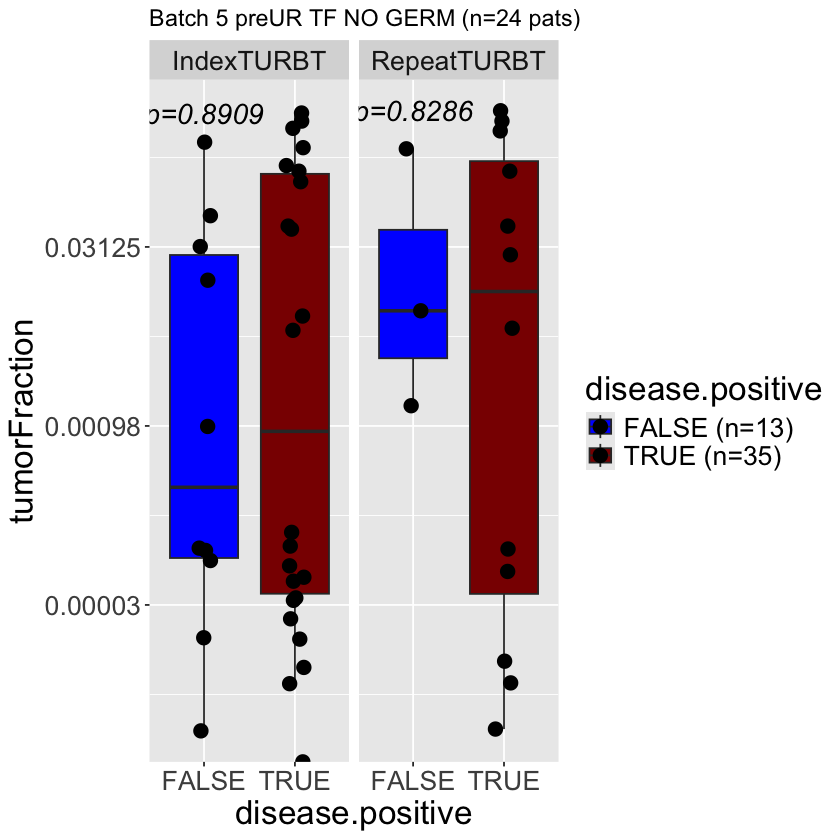

In [49]:
## batch 5 - no germ yet
source("~/Desktop/puffin/R/helper_functions.R")

mrd.info.5 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/batch_5_mrd_data/PD_mrd_analysis_batch5/WOP01651_WOP01646_WOP01656_PRDC-MOFFITT-NMIBC-22001_Other_all_2024-03-13.csv")
head(mrd.info.5)

df_ngsqc.preur <- mrd.info.5 #rbind.common(mrd.info.5, mrd.info.4)
df_ngsqc.preur = df_ngsqc.preur %>% filter(!grepl("specific|pool", Baseline, ignore.case = T))

df_ngsqc.preur = df_ngsqc.preur %>%
        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict")) %>% 
        select(-PatientID) %>% distinct()
nrow(df_ngsqc.preur)

#df_ngsqc.urine.mrd %>% filter(grepl("fail", QC_Status, ignore.case=TRUE)) # none

#### add sample studyvisit and PID
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
                        rename("StudyVisit.sample"="StudyVisit", "PatientID.sample"="PatientID", 
                               "SampleID.short.sample"="SampleID.short", "SampleID.sample"="SampleID") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
                               StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
                               PatientID.old.sample = PatientID.sample,
                               PatientID.sample = as.character(fix_PIDs(PatientID.old.sample)),
                               Baseline.short = make_SIDshort(Baseline, "strict"))
nrow(df_ngsqc.preur)
### add baseline study visit
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by=c("Baseline.short"="SampleID.short")) %>%
                        rename("StudyVisit.baseline"="StudyVisit", "PatientID.baseline"="PatientID",
                               "SampleID.baseline"="Baseline") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.baseline),
                               StudyVisit.baseline = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.baseline, StudyVisit2))),
                               PatientID.old.baseline = PatientID.baseline,
                               PatientID.baseline = as.character(fix_PIDs(PatientID.old.baseline)))
nrow(df_ngsqc.preur)
head(df_ngsqc.preur)
#df_ngsqc.preur = df_ngsqc.preur %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()
df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")

# interesting to check TF of urine sampleID vs. basline=sampleID. Do we get TF.WES==TF.BEACON?
table(df_ngsqc.preur$SampleID.sample, df_ngsqc.preur$StudyVisit.baseline)

stopifnot(all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline))
#df_ngsqc.preur = df_ngsqc.preur %>% filter(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline) %>% relocate(PatientID, PatientID.baseline)


table(df_ngsqc.preur$StudyVisit.sample) 

# need new clin data for disease.positive for batch 5 patients
df_clin.new = read_excel("clinical_data/NMIBC_clinical_data_JL_Jan232024.xlsx", sheet = "Sheet1", n_max = 99, skip = 2)
df_clin.new = make_names(df_clin.new) %>% mutate(disease.positive = (Repeat.Tumor > 0),
                                                PatientID = as.character(PatientID))
head(df_clin.new)

df_ngsqc.preur_ = df_ngsqc.preur %>% mutate(PatientID = as.character(PatientID),
                                           StudyVisit.baseline = trimws(as.character(StudyVisit.baseline))) %>% 
    left_join(df_clin.new, by=c("PatientID"="PatientID")) %>% filter(StudyVisit.baseline != "Pre-RepeatTURBT")
head(df_ngsqc.preur_)

quick_boxplot(df = df_ngsqc.preur_, x = "disease.positive", y="tumorFraction", facet = "StudyVisit.baseline",
              log.axes = TRUE, colors=c("FALSE"="blue","TRUE"="darkred"), plot.title="Batch 5 preUR TF NO GERM (n=4)")


In [50]:
# batch 5 updated - PD to fix bugs - not run yet
source("~/Desktop/puffin/R/helper_functions.R")

mrd.info.5 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/batch_5_mrd_data/WOP01646_WOP01656_WOP01651_PRDC-MOFFITT-NMIBC-22001_Other_all_2024-01-07_updated.csv")
head(mrd.info.5)

df_ngsqc.preur <- mrd.info.5 #rbind.common(mrd.info.5, mrd.info.4)
df_ngsqc.preur = df_ngsqc.preur %>% filter(!grepl("specific|pool", Baseline, ignore.case = T))

df_ngsqc.preur = df_ngsqc.preur %>%
        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict")) %>% 
        select(-PatientID) %>% distinct()
nrow(df_ngsqc.preur)

#df_ngsqc.urine.mrd %>% filter(grepl("fail", QC_Status, ignore.case=TRUE)) # none

#### add sample studyvisit and PID
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
                        rename("StudyVisit.sample"="StudyVisit", "PatientID.sample"="PatientID", 
                               "SampleID.short.sample"="SampleID.short", "SampleID.sample"="SampleID") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
                               StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
                               PatientID.old.sample = PatientID.sample,
                               PatientID.sample = as.character(fix_PIDs(PatientID.old.sample)),
                               Baseline.short = make_SIDshort(Baseline, "strict"))
nrow(df_ngsqc.preur)
### add baseline study visit
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by=c("Baseline.short"="SampleID.short")) %>%
                        rename("StudyVisit.baseline"="StudyVisit", "PatientID.baseline"="PatientID",
                               "SampleID.baseline"="Baseline") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.baseline),
                               StudyVisit.baseline = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.baseline, StudyVisit2))),
                               PatientID.old.baseline = PatientID.baseline,
                               PatientID.baseline = as.character(fix_PIDs(PatientID.old.baseline)))
nrow(df_ngsqc.preur)
head(df_ngsqc.preur)
#df_ngsqc.preur = df_ngsqc.preur %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()
df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")

# interesting to check TF of urine sampleID vs. basline=sampleID. Do we get TF.WES==TF.BEACON?
table(df_ngsqc.preur$SampleID.sample, df_ngsqc.preur$StudyVisit.baseline)

stopifnot(all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline))
#df_ngsqc.preur = df_ngsqc.preur %>% filter(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline) %>% relocate(PatientID, PatientID.baseline)


table(df_ngsqc.preur$StudyVisit.sample) 

df_clin.new = read_excel("clinical_data/NMIBC_clinical_data_JL_Jan232024.xlsx", sheet = "Sheet1", n_max = 99, skip = 2)
df_clin.new = make_names(df_clin.new) %>% mutate(disease.positive = (Repeat.Tumor > 0),
                                                PatientID = as.character(PatientID))
head(df_clin.new)

df_ngsqc.preur_ = df_ngsqc.preur %>% mutate(PatientID = as.character(PatientID),
                                           StudyVisit.baseline = trimws(as.character(StudyVisit.baseline))) %>% 
    left_join(df_clin.new, by=c("PatientID"="PatientID")) %>% filter(StudyVisit.baseline != "Pre-RepeatTURBT")
head(df_ngsqc.preur_)

quick_boxplot(df = df_ngsqc.preur_, x = "disease.positive", y="tumorFraction", facet = "StudyVisit.baseline",
              log.axes = TRUE, colors=c("FALSE"="blue","TRUE"="darkred"), plot.title="Batch 5 preUR TF NO GERM (n=18 pats)")


,SampleID,PatientID,Baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,P217589,172602,P237608A01,66,66,93,38,5,3,3.250,4.000,5.250,TRUE,TRUE,1,0.01643517,0.02253594,0.02253594,2.22439,0.61093164,12.6580,0.40288,0.25316,0.03688783,0.03563412,0.03688783,0.009338522,0.043520000,0.04351976,PREDICINEMRD_V1B__P237608A01
2,P217589,172602,P220072,20,20,112,17,5,5,5.625,4.375,5.625,TRUE,TRUE,1,0.15700157,0.17055201,0.17055201,24.13925,0.21789905,6.8736,0.25551,0.19101,0.78271109,1.10542443,0.78271109,0.149505645,0.365310000,0.36531175,PREDICINEMRD_V1B__P237608A01
3,P217589,172602,P220072_Specific,20,20,112,17,5,5,5.625,4.375,5.625,TRUE,TRUE,1,0.15700157,0.17055201,0.17055201,24.13925,0.21789905,6.8736,0.25551,0.19101,0.78271109,1.10542443,0.78271109,0.149505645,0.365310000,0.36531175,PREDICINEMRD_V1B__P237608A01
4,P217589,172602,P217589,61,61,71,59,59,59,51.625,50.375,51.625,TRUE,FALSE,1,0.19801751,0.14718433,0.10198811,28.47358,0.05984647,29.3860,0.54871,0.45424,2.45936525,3.29025322,1.70416238,0.774098718,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01
5,P217589,172602,P217589_Specific,61,61,71,59,59,59,51.625,50.375,51.625,TRUE,FALSE,1,0.19801751,0.14718433,0.10198811,28.47358,0.05984647,29.3860,0.54871,0.45424,2.45936525,3.29025322,1.70416238,0.774098718,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01
6,P217589,NA,Pool,NA,NA,80,50,9,4,4.250,7.250,8.500,TRUE,TRUE,1,0.01746929,0.02208572,0.02208572,2.25405,NA,NA,NA,NA,NA,NA,NA,NA,0.009243093,NA,PREDICINEMRD_V1B__P237608A01


SampleID.short format: strict


[1] 12

[1] "172602" "196412" "195407" "193248" "189953"
SampleID.short format: strict


[1] 12

[1] "172602" "196412" "195407" "193248" "189953"


[1] 12

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,SampleID.short.sample,StudyVisit.sample,PatientID.sample,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P217589,P237608A01,66,66,93,38,5,3,3.25000,4.000,5.250,TRUE,TRUE,1,0.016435165,0.022535941,0.0225359409,2.224390,0.61093164,12.6580,0.40288,0.25316,0.036887828,0.035634121,0.036887828,0.0093385224,0.043520,0.04351976,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P237608,IndexTURBT,172602,172602
2,P217589,P220072,20,20,112,17,5,5,5.62500,4.375,5.625,TRUE,TRUE,1,0.157001567,0.170552006,0.1705520057,24.139250,0.21789905,6.8736,0.25551,0.19101,0.782711087,1.105424434,0.782711087,0.1495056448,0.365310,0.36531175,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P220072,RepeatTURBT,172602,172602
3,P217589,P217589,61,61,71,59,59,59,51.62500,50.375,51.625,TRUE,FALSE,1,0.198017506,0.147184333,0.1019881056,28.473581,0.05984647,29.3860,0.54871,0.45424,2.459365254,3.290253224,1.704162377,0.7740987179,0.436610,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P217589,Pre-RepeatTURBT,172602,172602
4,P237537A01,P237651A01,53,53,131,35,32,29,26.71053,27.586,29.711,TRUE,TRUE,3,0.043937073,0.048646644,0.0486466440,18.630296,0.30333855,95.0620,0.97468,0.97468,0.160370794,0.143522987,0.160370794,0.1563102052,0.314090,0.31409002,PREDICINEMRD_V1B__P237651A01,P237537,Pre-RepeatTURBT,196412,NA,196412,P237651,IndexTURBT,196412,196412
5,P237537A01,P237537A01,57,57,106,58,57,57,54.23026,52.105,54.230,TRUE,FALSE,3,0.086906748,0.084454674,0.0531086839,23.670886,0.04258735,24.2980,0.36614,0.36614,1.983092931,2.040670455,1.247053009,0.4565959886,0.382800,0.38280450,PREDICINEMRD_V1B__P237651A01,P237537,Pre-RepeatTURBT,196412,NA,196412,P237537,Pre-RepeatTURBT,196412,196412
6,P237545A01,P237619A01,67,67,106,59,54,53,36.98369,36.984,36.984,TRUE,TRUE,0,0.001318306,0.000543251,0.0003847813,1.598607,0.21765569,34.9650,0.67510,0.51852,0.002495919,0.006030404,0.001767844,0.0009166626,0.031469,0.03146908,PREDICINEMRD_V1B__P237619A01,P237545,Pre-RepeatTURBT,195407,NA,195407,P237619,IndexTURBT,195407,195407


            
             IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  P217589             1               1           1    0
  P237537A01          1               1           0    0
  P237545A01          1               1           1    0
  P237577A01          1               1           0    0
  P237583A01          1               1           0    0
  <NA>                0               0           0    0


Pre-RepeatTURBT            <NA> 
             12               0 

PatientID,Recurrence.Follow.Up,Repeat.Tumor,disease.positive
<chr>,<dbl>,<dbl>,<lgl>
76224,1,3,TRUE
116381,1,3,TRUE
152237,0,0,FALSE
161922,1,0,FALSE
165028,1,4,TRUE
167162,0,4,TRUE


,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline,Recurrence.Follow.Up,Repeat.Tumor,disease.positive
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,P217589,P237608A01,66,66,93,38,5,3,3.25000,4.000,5.250,TRUE,TRUE,1,0.016435165,0.022535941,0.0225359409,2.224390,0.6109316,12.6580,0.40288,0.25316,0.036887828,0.035634121,0.036887828,0.0093385224,0.043520,0.04351976,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P237608,IndexTURBT,172602,172602,1,1,TRUE
2,P217589,P220072,20,20,112,17,5,5,5.62500,4.375,5.625,TRUE,TRUE,1,0.157001567,0.170552006,0.1705520057,24.139250,0.2178991,6.8736,0.25551,0.19101,0.782711087,1.105424434,0.782711087,0.1495056448,0.365310,0.36531175,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P220072,RepeatTURBT,172602,172602,1,1,TRUE
3,P237537A01,P237651A01,53,53,131,35,32,29,26.71053,27.586,29.711,TRUE,TRUE,3,0.043937073,0.048646644,0.0486466440,18.630296,0.3033385,95.0620,0.97468,0.97468,0.160370794,0.143522987,0.160370794,0.1563102052,0.314090,0.31409002,PREDICINEMRD_V1B__P237651A01,P237537,Pre-RepeatTURBT,196412,NA,196412,P237651,IndexTURBT,196412,196412,0,3,TRUE
4,P237545A01,P237619A01,67,67,106,59,54,53,36.98369,36.984,36.984,TRUE,TRUE,0,0.001318306,0.000543251,0.0003847813,1.598607,0.2176557,34.9650,0.67510,0.51852,0.002495919,0.006030404,0.001767844,0.0009166626,0.031469,0.03146908,PREDICINEMRD_V1B__P237619A01,P237545,Pre-RepeatTURBT,195407,NA,195407,P237619,IndexTURBT,195407,195407,NA,0,FALSE
5,P237545A01,P237643A01,5,5,161,4,3,0,0.00000,0.000,0.000,FALSE,FALSE,0,NA,NA,NA,NA,NA,49.5650,0.66279,0.66279,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P237619A01,P237545,Pre-RepeatTURBT,195407,NA,195407,P237643,RepeatTURBT,195407,195407,NA,0,FALSE
6,P237577A01,P237620A01,42,42,122,31,31,31,28.12500,25.375,28.125,TRUE,FALSE,4,0.331888173,0.269050513,0.2690505132,57.582774,0.2347148,69.4440,0.79775,0.79775,1.146286889,1.414006078,1.146286889,0.9144503658,0.730830,0.73082574,PREDICINEMRD_V1B__P237620A01,P237577,Pre-RepeatTURBT,193248,NA,193248,P237620,IndexTURBT,193248,193248,0,3,TRUE


  disease.positive tumorFraction StudyVisit.baseline
1             TRUE     0.0435200          IndexTURBT
2             TRUE     0.3653100         RepeatTURBT
3             TRUE     0.3140900          IndexTURBT
4            FALSE     0.0314690          IndexTURBT
5            FALSE            NA         RepeatTURBT
6             TRUE     0.7308300          IndexTURBT
7             TRUE     0.0062167          IndexTURBT
Complete cases tumorFraction by disease.positive: 6
[1] "FALSE" "TRUE" 
      disease.positive count      legend   color
FALSE            FALSE     1 FALSE (n=1)    blue
TRUE              TRUE     5  TRUE (n=5) darkred
[1] "y"
  disease.positive tumorFraction StudyVisit.baseline
1             TRUE     0.0435200          IndexTURBT
2             TRUE     0.3653100         RepeatTURBT
3             TRUE     0.3140900          IndexTURBT
4            FALSE     0.0314690          IndexTURBT
6             TRUE     0.7308300          IndexTURBT
7             TRUE     0.006216

ERROR: Error in wilcox.test.default(lev1_vals, not_lev1_vals, exact = FALSE, : not enough (non-missing) 'x' observations
